In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import style
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

style.use("dark_background")
plt.rcParams.update({"figure.figsize": (10, 7), "figure.dpi": 100})

In [8]:
%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [6]:
df = pd.read_csv(
    "../data/acceleration.csv", header=1, parse_dates=["Time"], index_col="Time"
)
df.columns = ["acceleration"]
df["acceleration"] = df["acceleration"].str.replace(" m/s²", "").astype("float32")
# df["acceleration"] = pd.to_numeric(df["acceleration"], downcast="float")
df.head()

acceleration
Time                             
2021-12-09 09:42:35          15.0
2021-12-09 09:43:35          15.5
2021-12-09 09:44:35          15.1
2021-12-09 09:45:35          14.7
2021-12-09 09:46:36          13.0

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262154 entries, 2021-12-09 09:42:35 to 2022-06-09 09:41:31
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   acceleration  262154 non-null  float32
dtypes: float32(1)
memory usage: 3.0 MB


# 1. Data Understanding

#### How many values under 12 do we have? And how many missing values?

In [52]:
df.loc[df["acceleration"] < 0.2, :].count()

acceleration    73724
dtype: int64

In [53]:
df.isnull().sum()

acceleration    0
dtype: int64

In [54]:
# df.fillna(method="backfill", inplace=True)

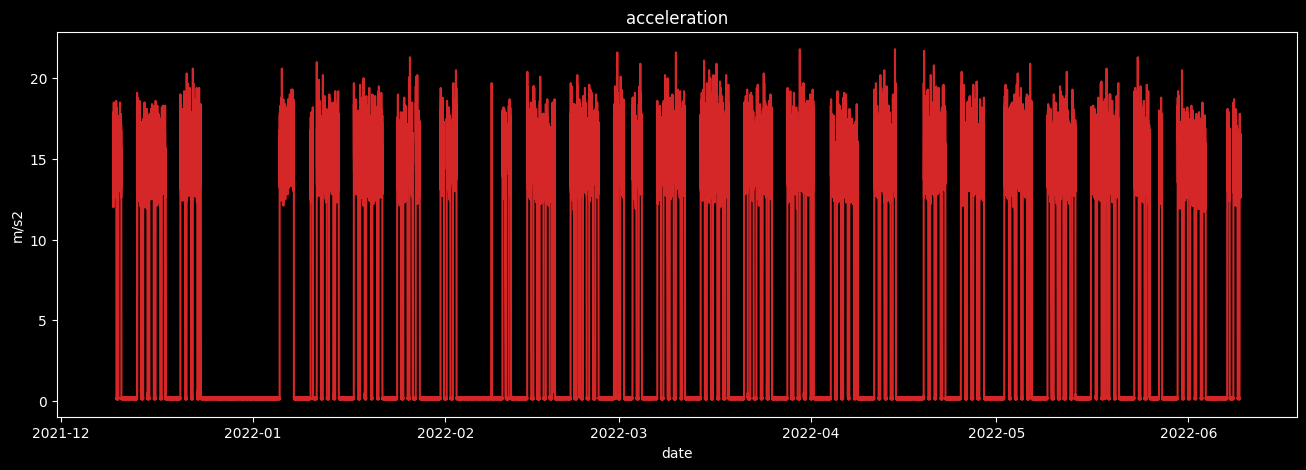

In [55]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df.index, df["acceleration"], color="tab:red")
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title="acceleration", xlabel="date", ylabel="m/s2")
plt.show()

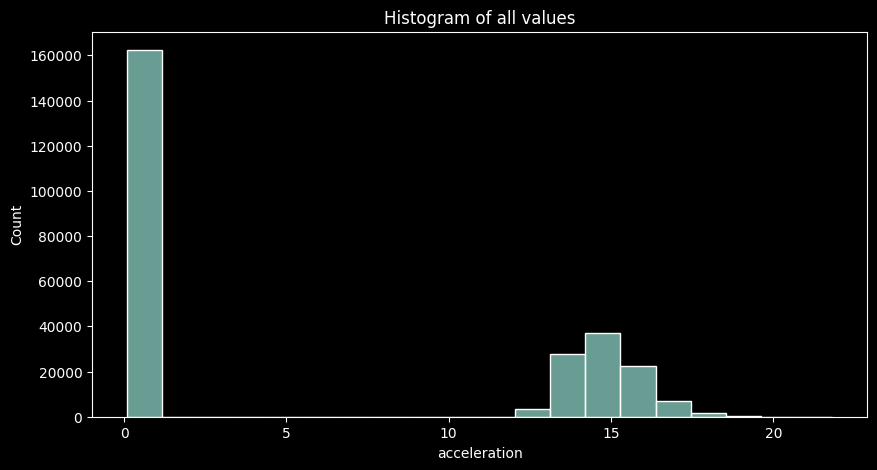

In [56]:
# Histogram with 3 standard deviations
plt.figure(figsize=(10, 5), dpi=100)
sns.histplot(df["acceleration"], bins=20)
plt.title("Histogram of all values")
plt.show()

In [57]:
df["acceleration"].describe()

count    262154.000000
mean          5.732547
std           7.151464
min           0.100000
25%           0.100000
50%           0.200000
75%          14.300000
max          21.799999
Name: acceleration, dtype: float64

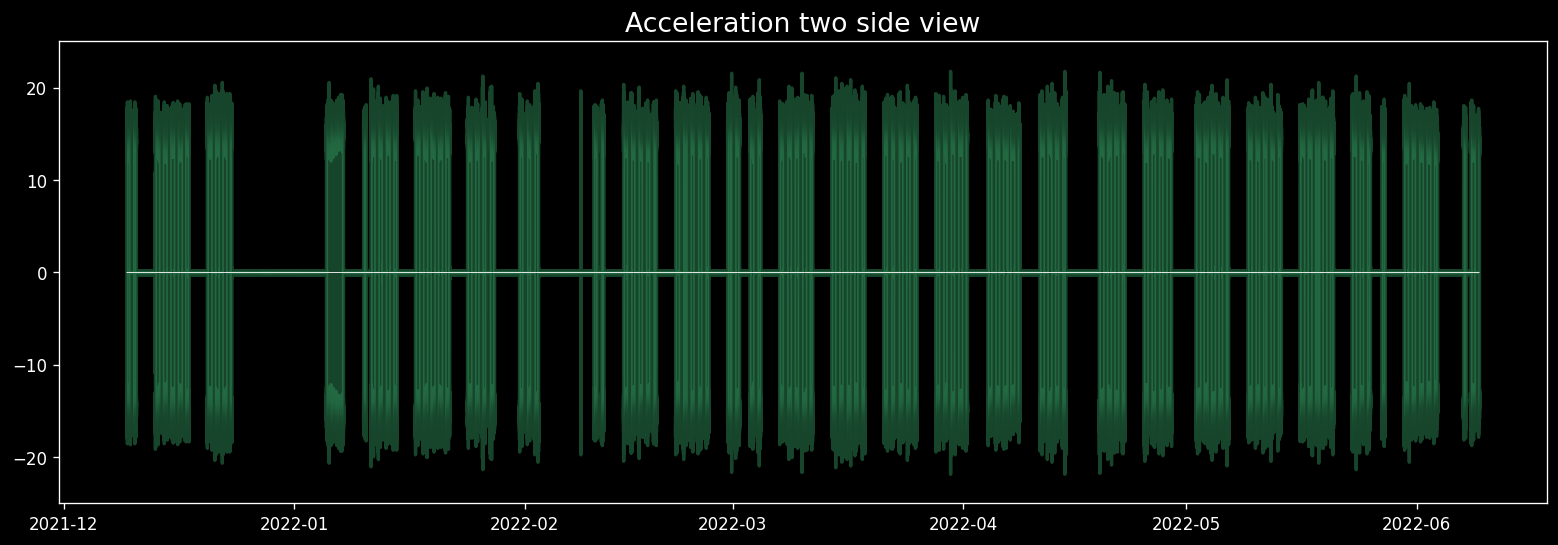

In [58]:
# Mirror axis
fig, ax = plt.subplots(1, 1, figsize=(16, 5), dpi=120)
plt.fill_between(
    df.index,
    y1=df["acceleration"],
    y2=-df["acceleration"],
    alpha=0.5,
    linewidth=2,
    color="seagreen",
)
plt.ylim(-25, 25)
plt.title("Acceleration two side view", fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=0.5)
plt.show()

In [59]:
df_hour = df.resample("H").median()
df_hour["weekday"] = [d.strftime("%a") for d in df_hour.index]
df_hour["hour"] = [d.strftime("%H") for d in df_hour.index]
df_hour["yearweek"] = [d.strftime("%W") for d in df_hour.index]
df_hour["month"] = [d.strftime("%b") for d in df_hour.index]
df_hour["yearday"] = [d.strftime("%j") for d in df_hour.index]
df_hour["year"] = [d.strftime("%Y") for d in df_hour.index]
df_hour["hour"] = df_hour["hour"].astype(int)

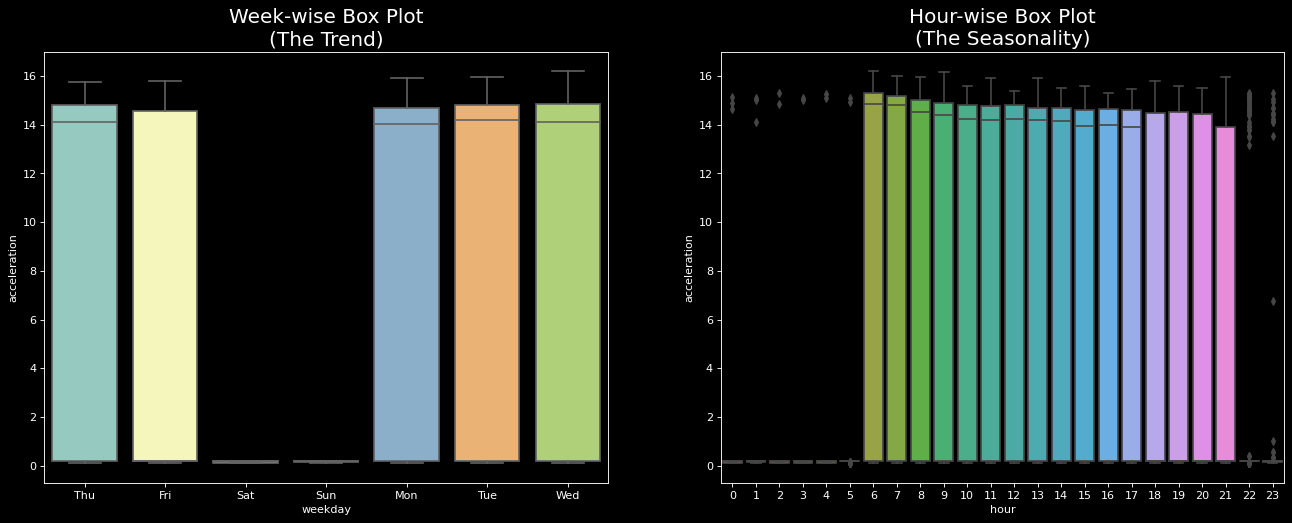

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x="weekday", y="acceleration", data=df_hour, ax=axes[0])
sns.boxplot(
    x="hour", y="acceleration", data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :]
)

# Set Title
axes[0].set_title("Week-wise Box Plot\n(The Trend)", fontsize=18)
axes[1].set_title("Hour-wise Box Plot\n(The Seasonality)", fontsize=18)
plt.show()

## Correlation and Decomposition

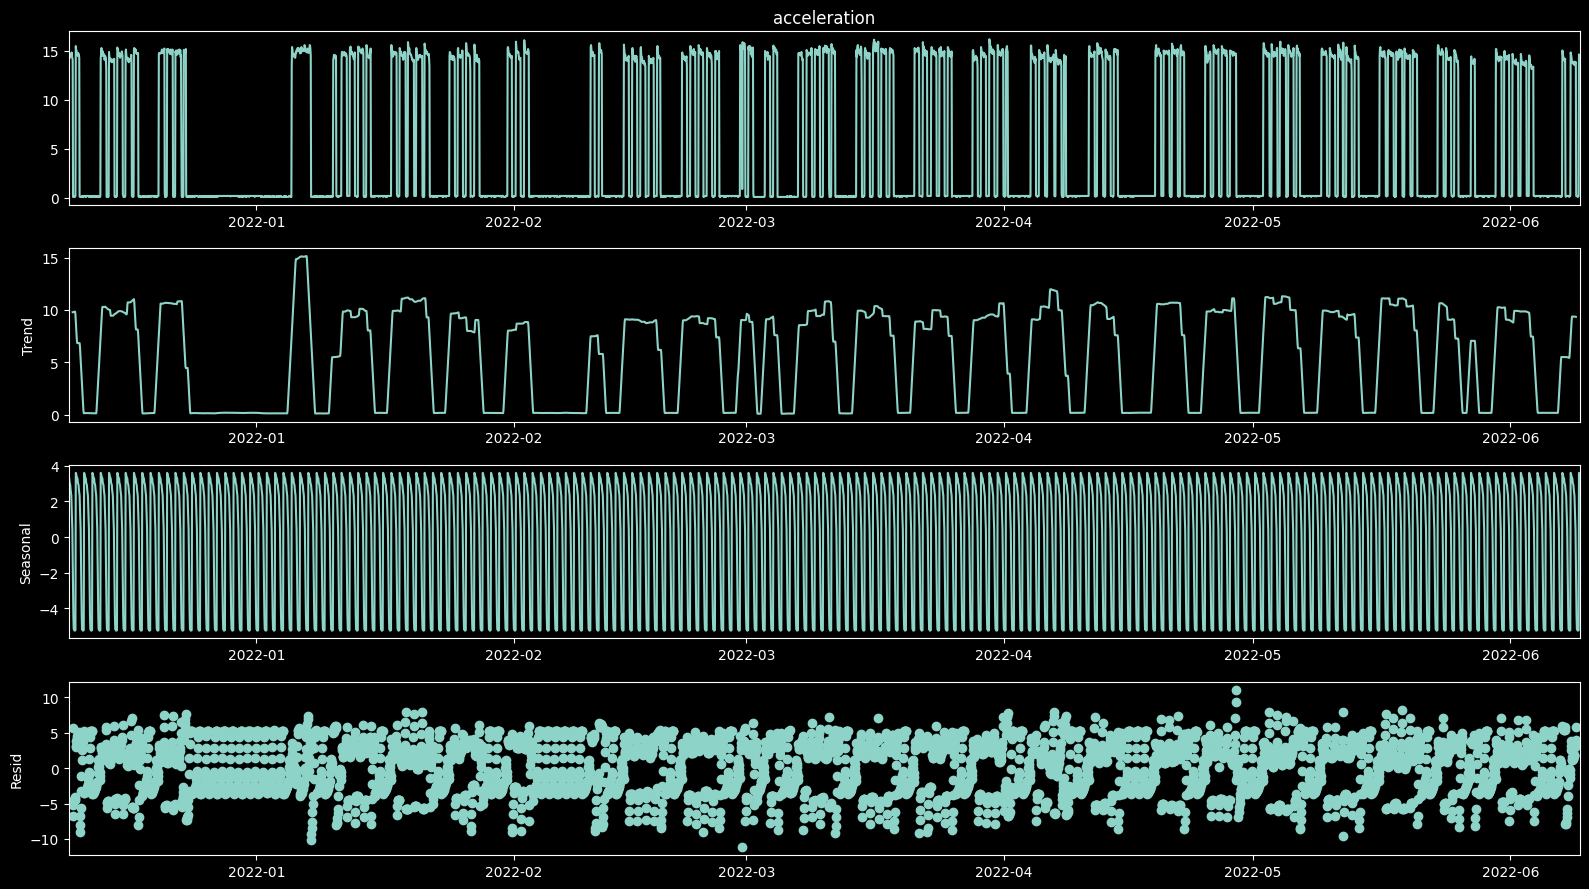

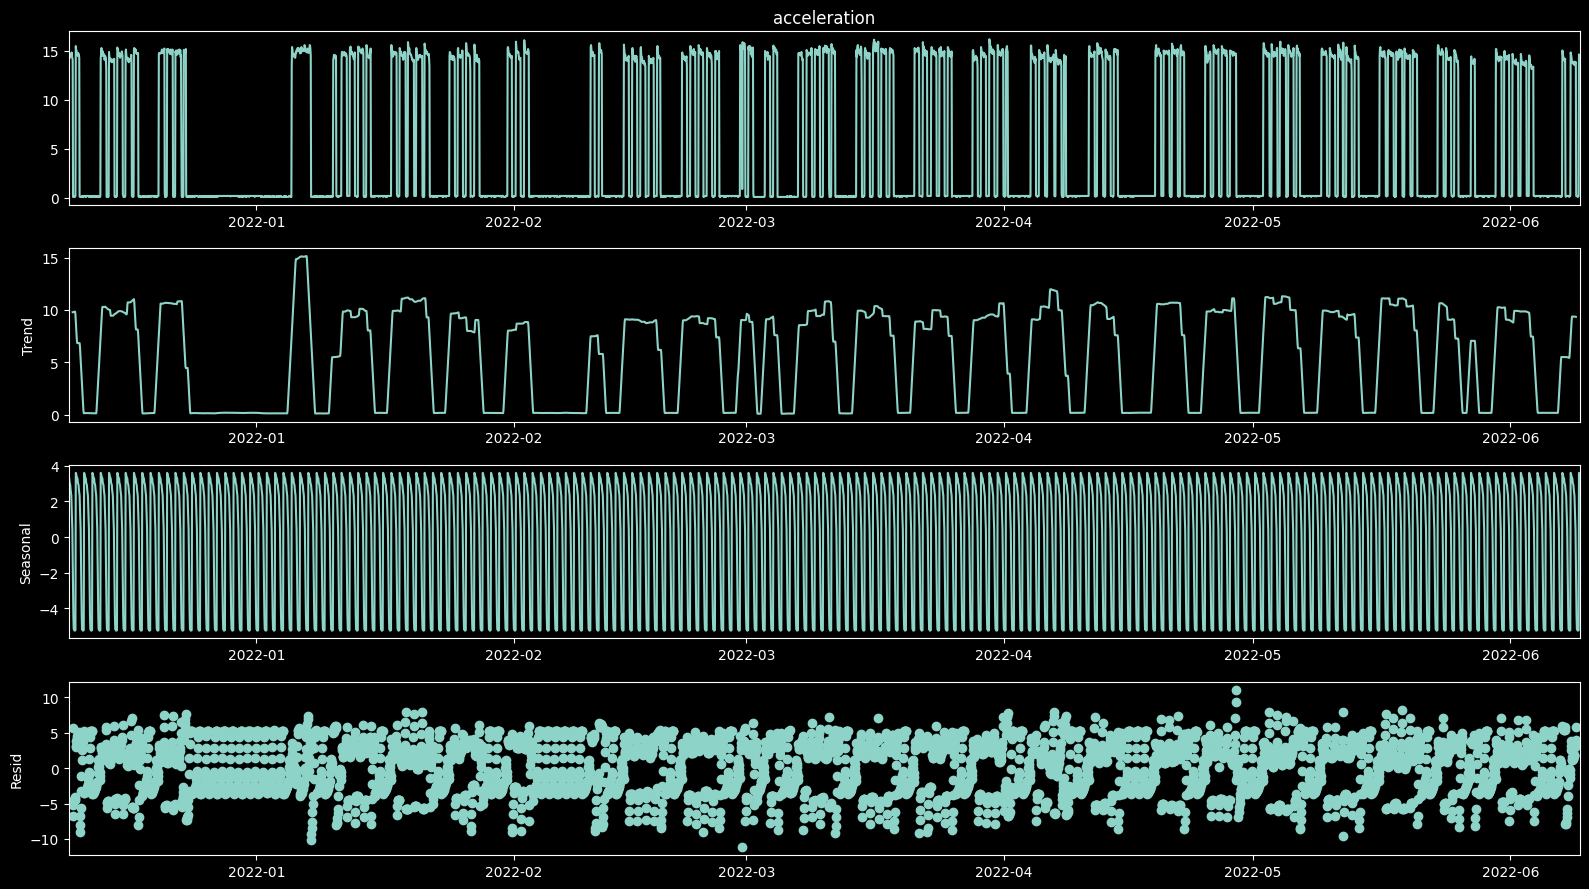

In [61]:
df_hour["acceleration"] = df_hour["acceleration"].fillna(method="backfill")
decomposition = sm.tsa.seasonal_decompose(df_hour["acceleration"])
rcParams["figure.figsize"] = 16, 9
decomposition.plot()

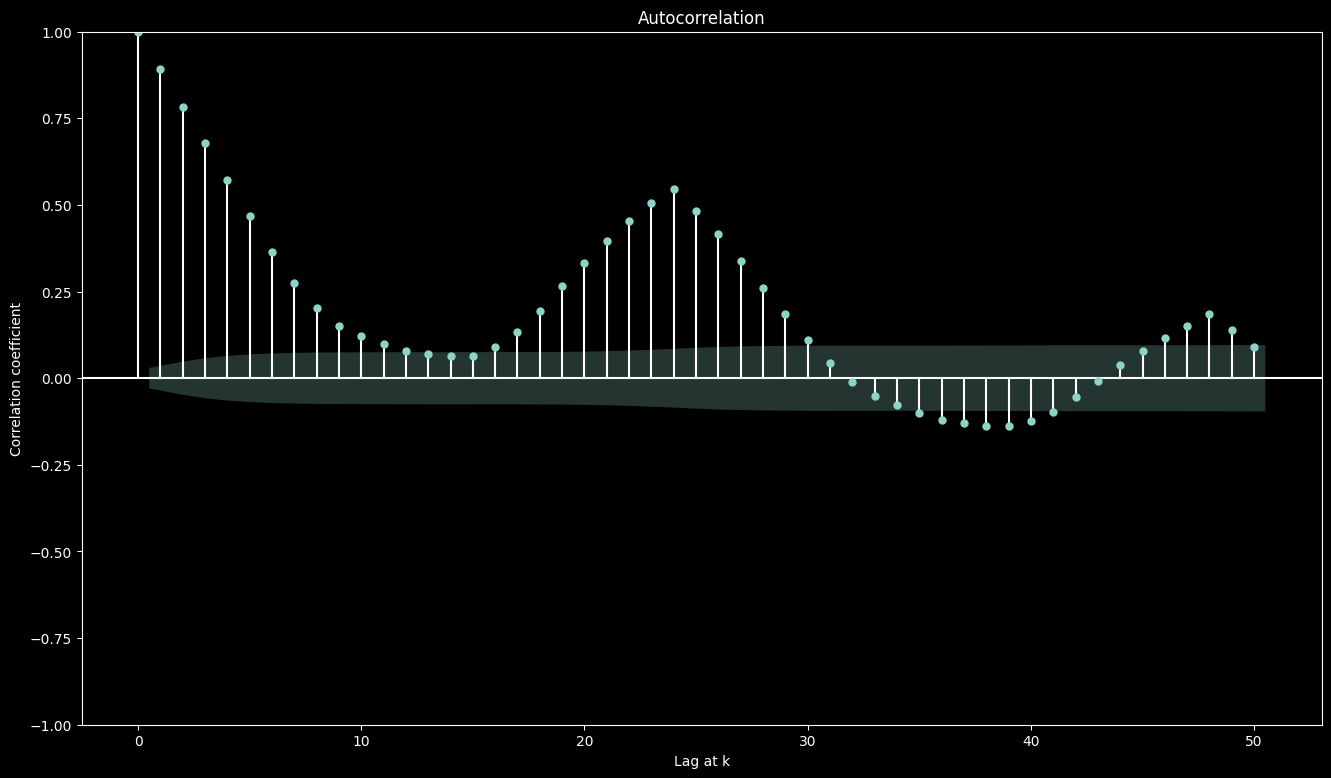

In [62]:
from statsmodels.graphics import tsaplots

# Stands for Time Series Analysis Plots (TSA Plots)
# Using pearson correlation cofficient (between -1 and 1)
fig = tsaplots.plot_acf(df_hour["acceleration"], lags=50)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

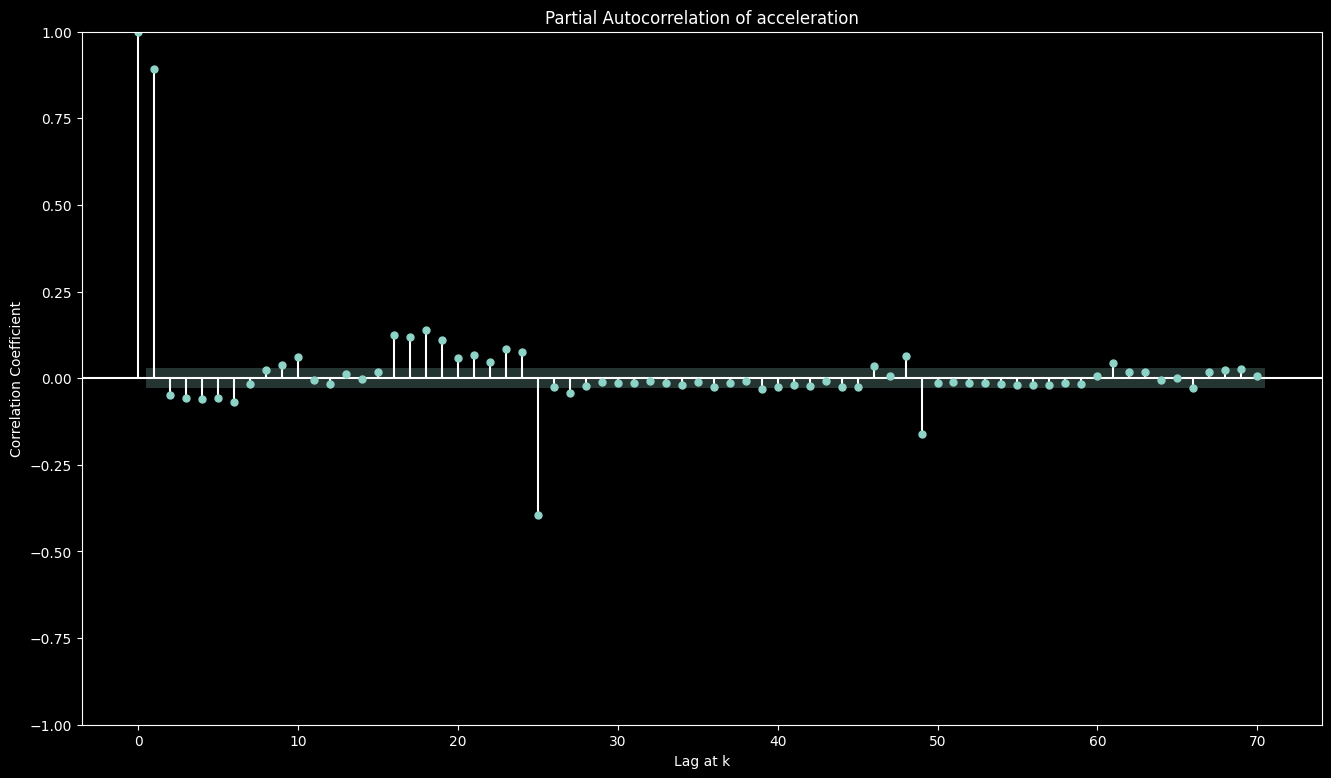

In [63]:
fig = tsaplots.plot_pacf(df_hour["acceleration"], lags=70, method="ywm")

plt.title("Partial Autocorrelation of acceleration")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

### Test removing some values, processwise these values mean the machine is off

In [64]:
# Explore the whole series without lower values
df_hour = df_hour[df_hour["acceleration"] > 12]
df_hour

acceleration weekday  hour yearweek month yearday  year
Time                                                                        
2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343  2021
2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343  2021
2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343  2021
2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343  2021
2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343  2021
...                           ...     ...   ...      ...   ...     ...   ...
2022-06-08 21:00:00         13.85     Wed    21       23   Jun     159  2022
2022-06-09 06:00:00         14.65     Thu     6       23   Jun     160  2022
2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160  2022
2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160  2022
2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160  2022

[1638 rows x 7 columns]

### Visualize

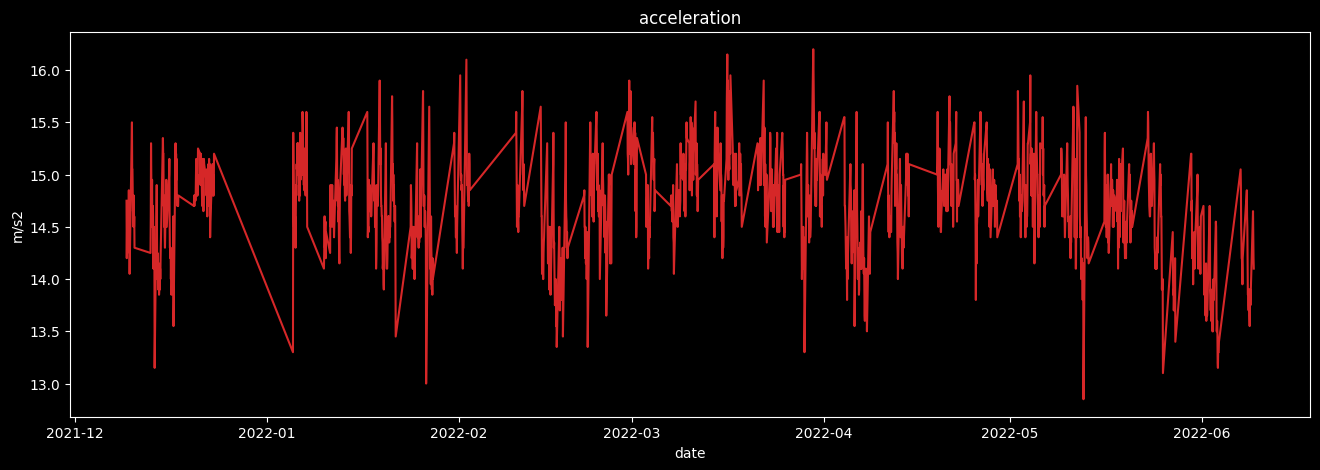

In [65]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_hour.index, df_hour["acceleration"], color="tab:red")
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title="acceleration", xlabel="date", ylabel="m/s2")
plt.show()

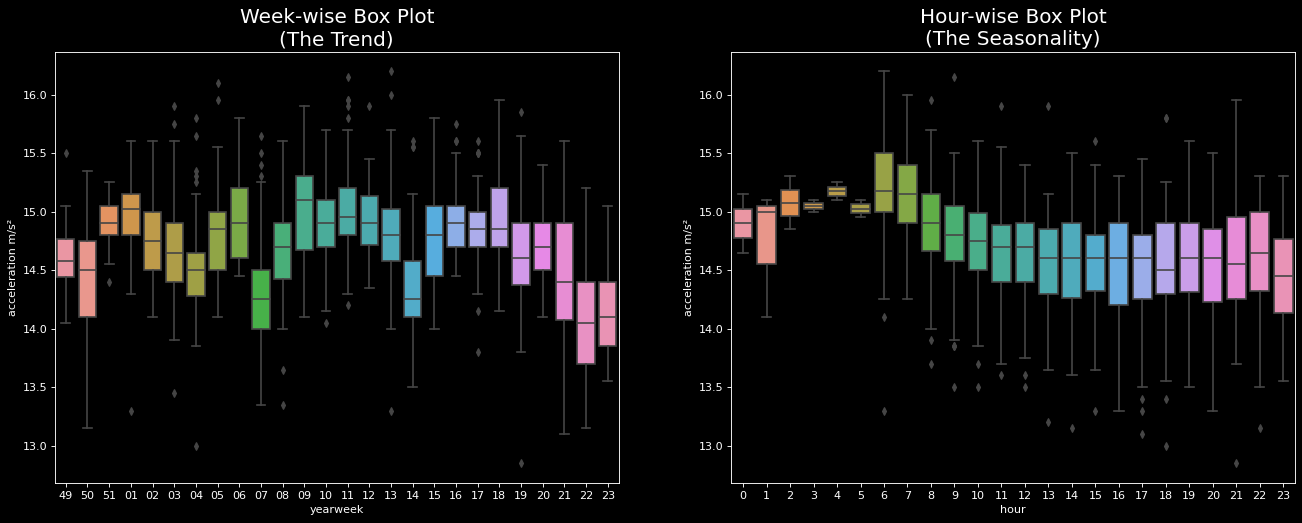

In [66]:
# Box plot of daily based on week of the year

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x="yearweek", y="acceleration", data=df_hour, ax=axes[0]).set(
    ylabel="acceleration m/s²"
)
sns.boxplot(
    x="hour", y="acceleration", data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :]
).set(ylabel="acceleration m/s²")

# Set Title
axes[0].set_title("Week-wise Box Plot\n(The Trend)", fontsize=18)
axes[1].set_title("Hour-wise Box Plot\n(The Seasonality)", fontsize=18)
plt.show()

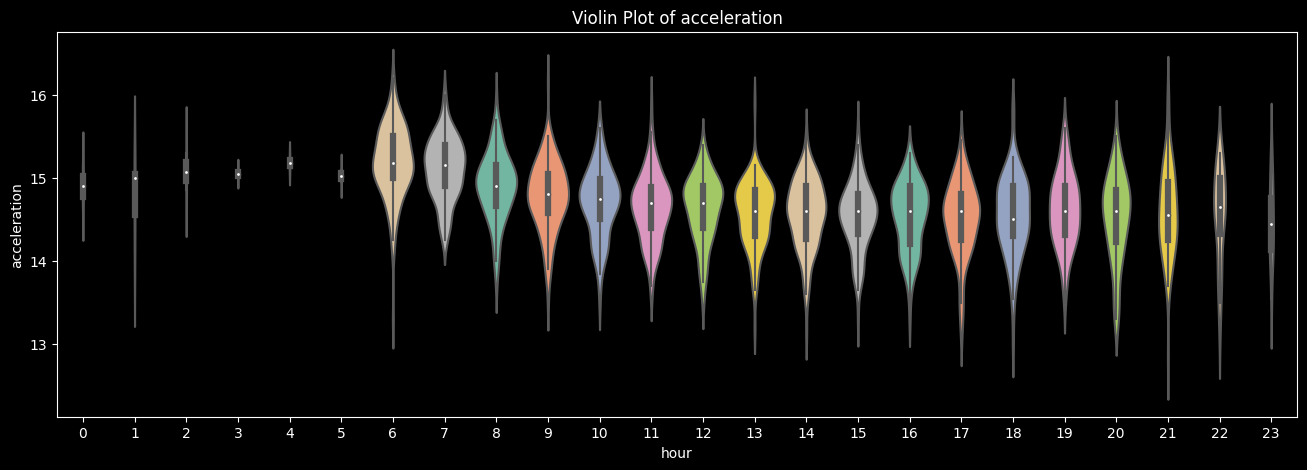

In [67]:
plt.figure(figsize=(16, 5), dpi=100)
ax = sns.violinplot(
    x="hour",
    y="acceleration",
    data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :],
    palette="Set2",
    split=True,
    scale="count",
    title="Violin plot",
).set_title("Violin Plot of acceleration")

plt.show()

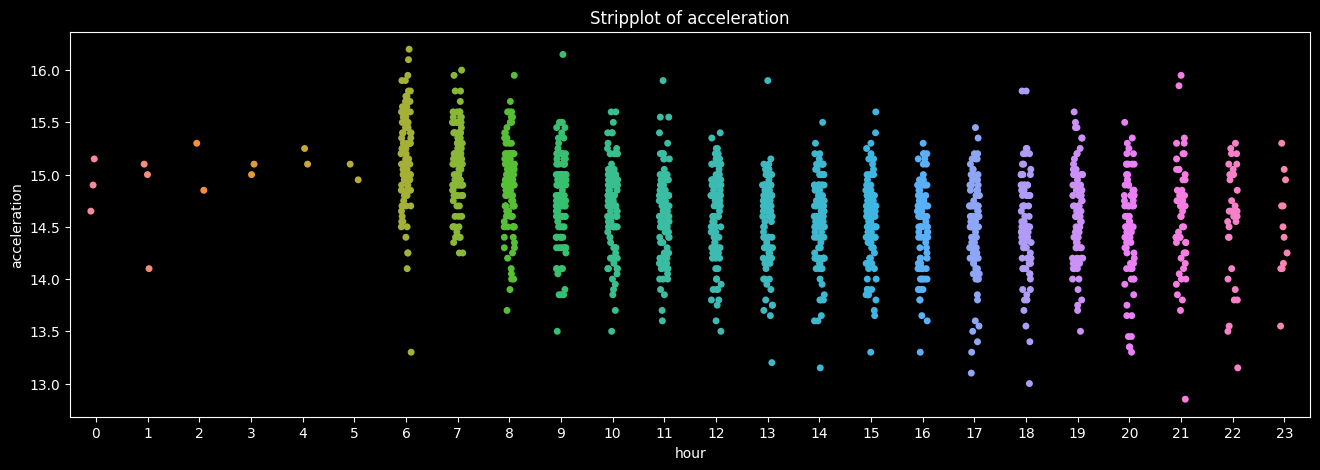

In [68]:
plt.figure(figsize=(16, 5), dpi=100)
ax = sns.stripplot(
    x="hour", y="acceleration", data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :]
).set_title("Stripplot of acceleration")
plt.show()

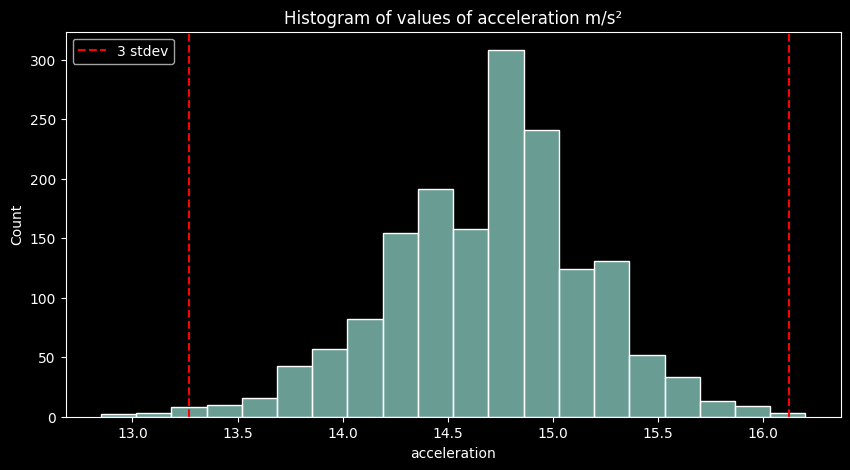

In [69]:
# Histogram with 3 standard deviations
plt.figure(figsize=(10, 5), dpi=100)
# plt.hist(df_hour['acceleration'], bins = 20
sns.histplot(df_hour["acceleration"], bins=20)
plt.axvline(
    x=df_hour["acceleration"].mean() + 3 * df_hour["acceleration"].std(),
    color="red",
    ls="--",
)
plt.axvline(
    x=df_hour["acceleration"].mean() - 3 * df_hour["acceleration"].std(),
    color="red",
    ls="--",
    label="3 stdev",
)
plt.legend()
plt.title("Histogram of values of acceleration m/s²")
plt.show()

#### Of course without our outliers the mean will fall within the normal operation range

In [70]:
df_hour["acceleration"].describe()

count    1638.000000
mean       14.694078
std         0.475250
min        12.850000
25%        14.400000
50%        14.700000
75%        15.000000
max        16.200001
Name: acceleration, dtype: float64

#### The jumps in the datapoints are due to the values we removed

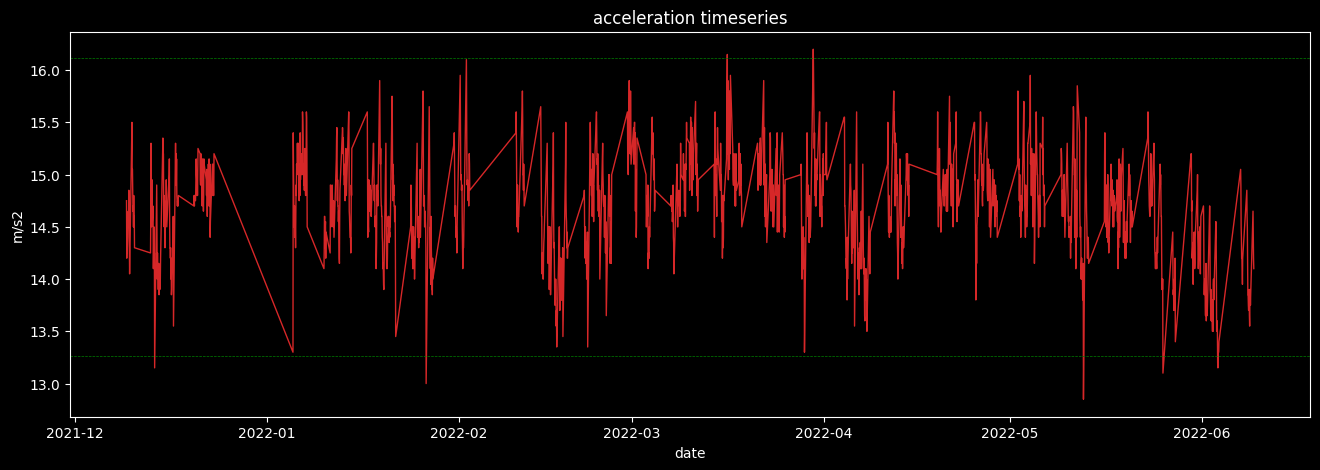

In [71]:
# Everything above or below the green bars is outside statistical normality
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_hour.index, df_hour["acceleration"], color="tab:red", linewidth=1)
plt.axhline(
    y=df_hour["acceleration"].mean() + 3 * df_hour["acceleration"].std(),
    color="green",
    ls="--",
    linewidth=0.5,
)
plt.axhline(
    y=df_hour["acceleration"].mean() - 3 * df_hour["acceleration"].std(),
    color="green",
    ls="--",
    linewidth=0.5,
)

plt.gca().set(title="acceleration timeseries", xlabel="date", ylabel="m/s2")
plt.show()

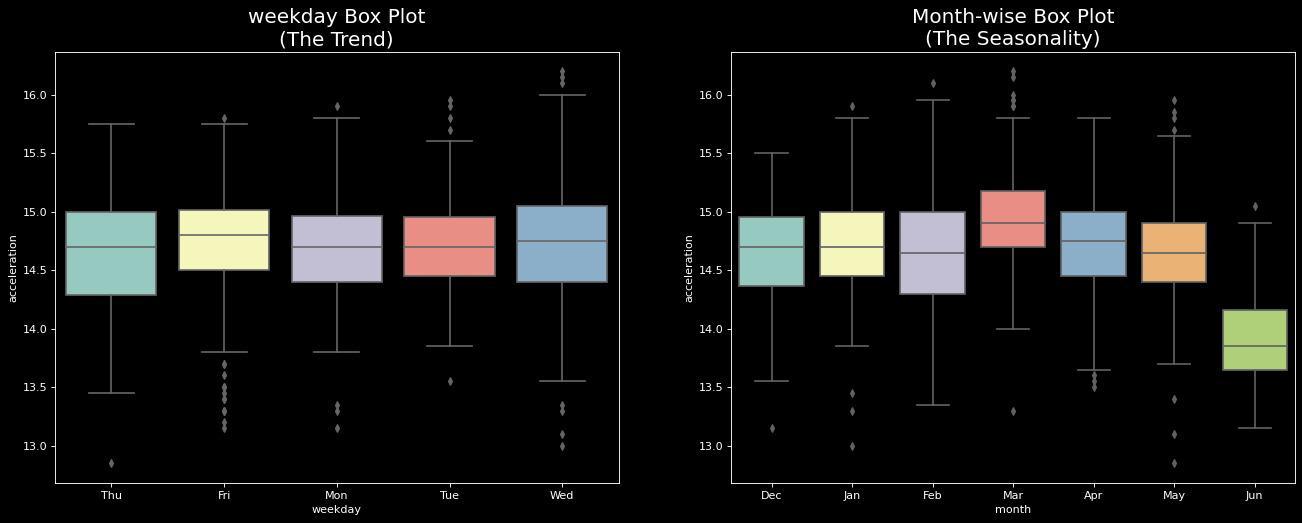

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=80)
sns.boxplot(x="weekday", y="acceleration", data=df_hour, ax=axes[0])
sns.boxplot(
    x="month", y="acceleration", data=df_hour.loc[~df_hour.yearweek.isin([1, 52]), :]
)

# Set Title
axes[0].set_title("weekday Box Plot\n(The Trend)", fontsize=18)
axes[1].set_title("Month-wise Box Plot\n(The Seasonality)", fontsize=18)
plt.show()

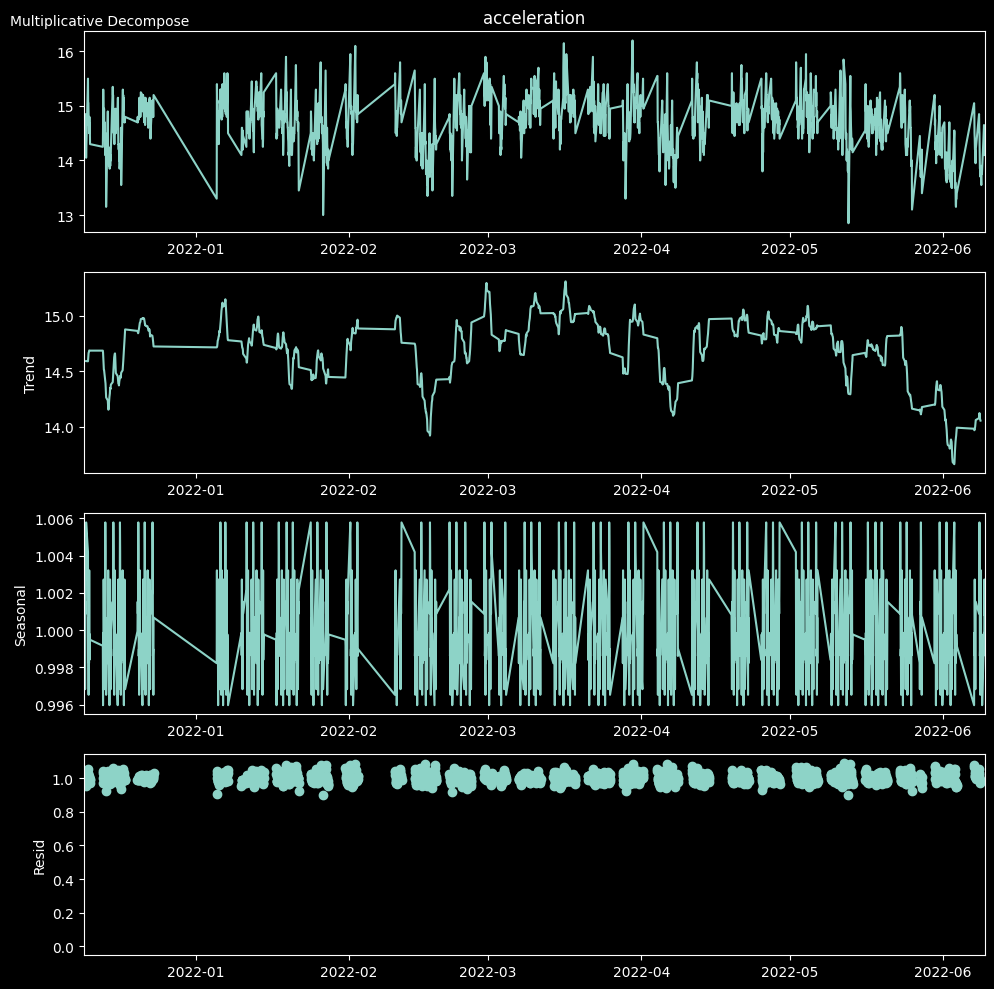

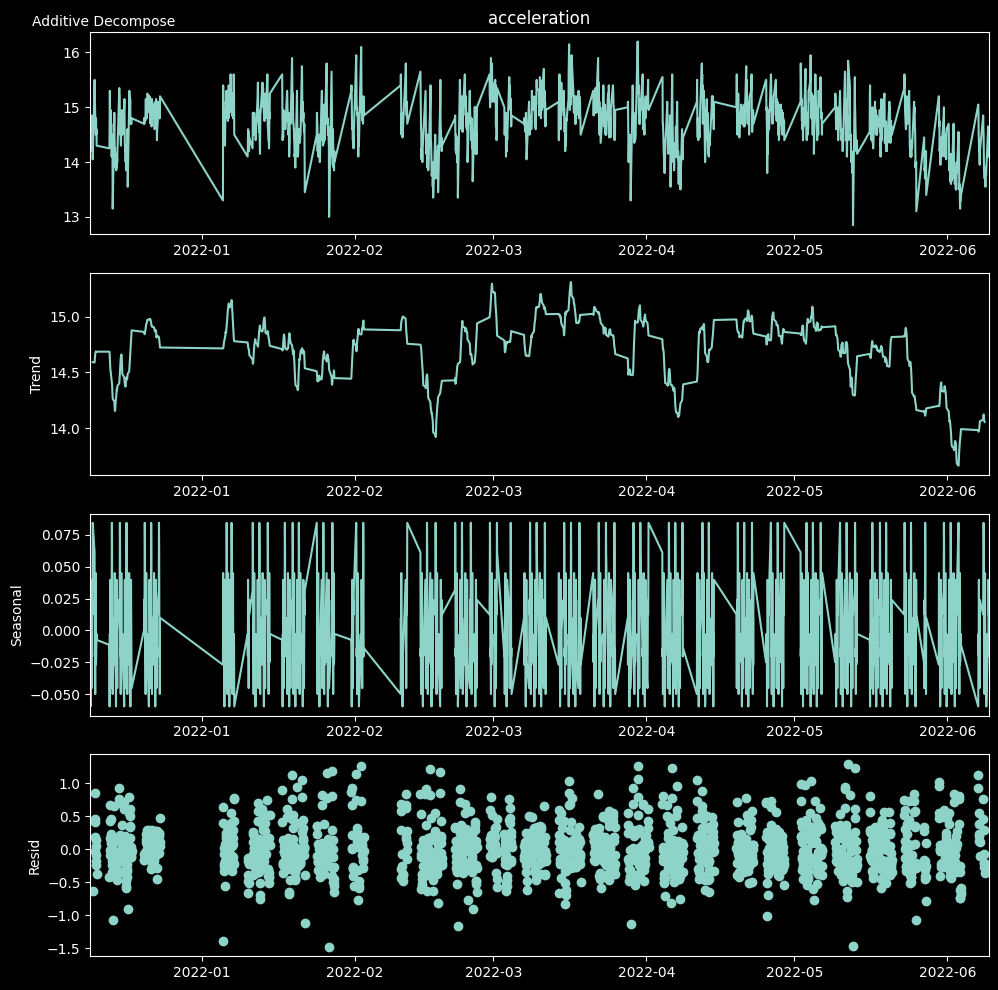

In [73]:
# Lets do some seasonality calculation adn division, we can start with additive time series
# Value = Base Level + Trend + Seasonality + Error

# Multiplicative Decomposition

result_mul = seasonal_decompose(
    df_hour["acceleration"], model="multiplicative", period=24
)

# Additive Decomposition
result_add = seasonal_decompose(df_hour["acceleration"], model="additive", period=24)

# Plot

plt.rcParams.update({"figure.figsize": (10, 10)})
result_mul.plot().suptitle("Multiplicative Decompose", fontsize=10, x=0.1)
result_add.plot().suptitle("Additive Decompose", fontsize=10, x=0.1)

plt.show()

## Calculate statistical significance, Dickey-Fuller test and KPSS test

In [74]:
result = adfuller(df_hour.acceleration.values, autolag="AIC")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

# KPSS Test
result = kpss(df_hour.acceleration.values, regression="c")
print("\nKPSS Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[3].items():
    print("Critial Values:")
    print(f"   {key}, {value}")

ADF Statistic: -4.906212972980001
p-value: 3.3916136234821335e-05
Critial Values:
   1%, -3.4343880265995215
Critial Values:
   5%, -2.8633235546096194
Critial Values:
   10%, -2.56771952639493

KPSS Statistic: 0.607350
p-value: 0.021968
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


### Rolling Statistics to check if data is stationary

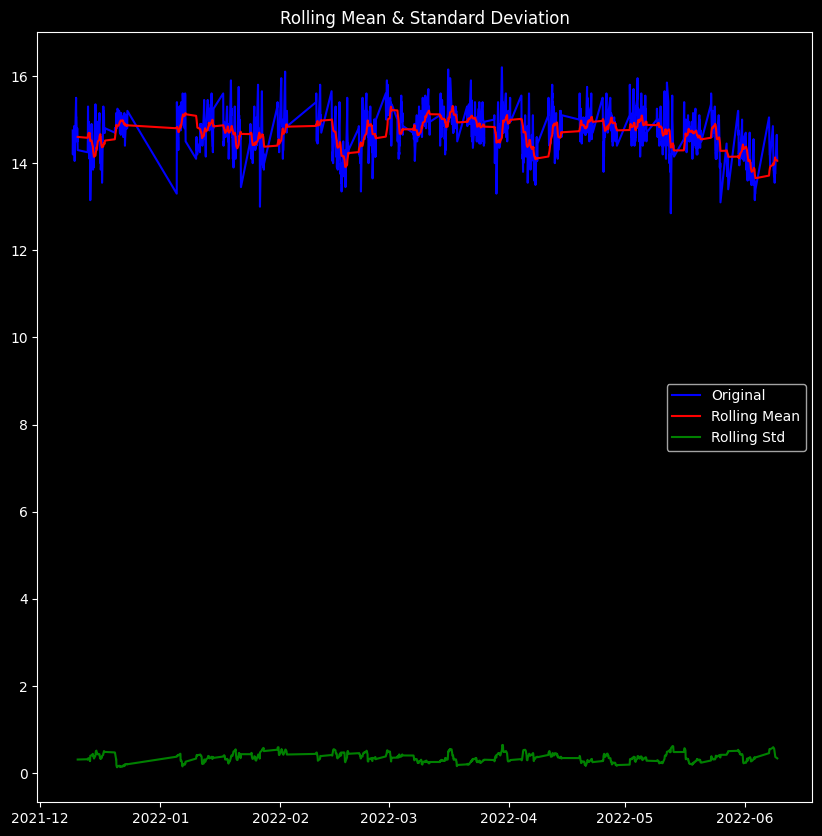

Results of Dickey-Fuller Test:


Test Statistic                   -4.906213
p-value                           0.000034
#Lags Used                       15.000000
Number of Observations Used    1622.000000
Critical Value (1%)              -3.434388
Critical Value (5%)              -2.863324
Critical Value (10%)             -2.567720
dtype: float64

In [75]:
rolmean = df_hour["acceleration"].rolling(24).mean()
rolstd = df_hour["acceleration"].rolling(24).std()
# Plot rolling statistics:
plt.plot(df_hour["acceleration"], color="blue", label="Original")
plt.plot(rolmean, color="red", label="Rolling Mean")
plt.plot(rolstd, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df_hour["acceleration"], autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
dfoutput

### Transforming data

In [76]:
smooth_df_hour = df_hour["acceleration"] - rolmean
smooth_df_hour.dropna(inplace=True)
smooth_df_hour

Time
2021-12-10 16:00:00   -0.302084
2021-12-13 06:00:00   -0.331250
2021-12-13 07:00:00    0.002084
2021-12-13 08:00:00    0.666667
2021-12-13 09:00:00    0.335417
                         ...   
2022-06-08 21:00:00   -0.231250
2022-06-09 06:00:00    0.579166
2022-06-09 07:00:00    0.333333
2022-06-09 08:00:00    0.141666
2022-06-09 09:00:00    0.045834
Name: acceleration, Length: 1615, dtype: float64

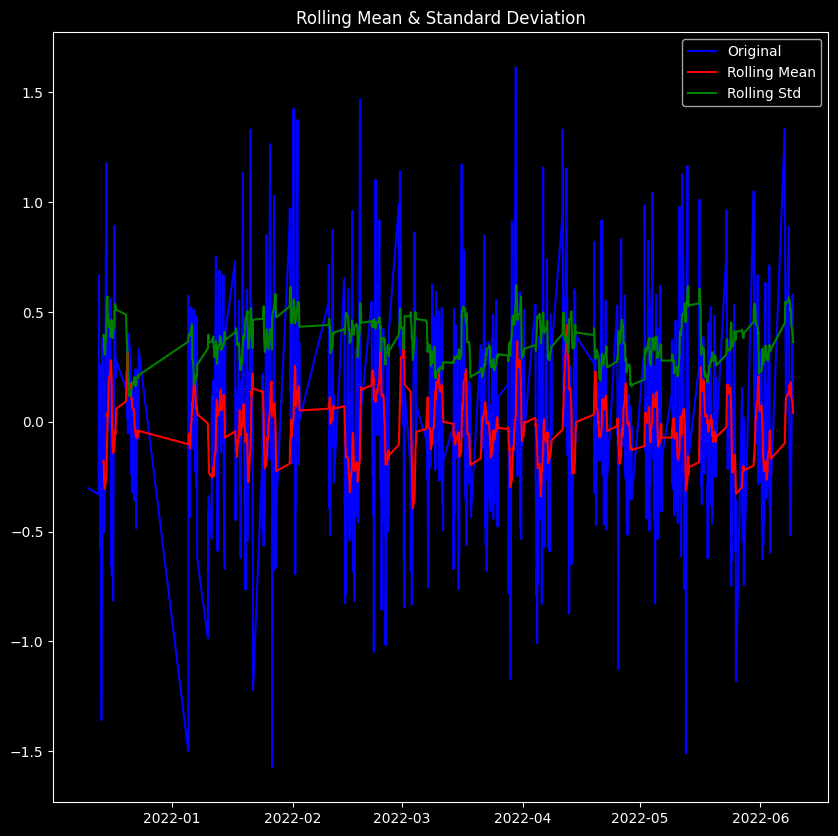

Results of Dickey-Fuller Test:


Test Statistic                -1.174391e+01
p-value                        1.254636e-21
#Lags Used                     2.000000e+01
Number of Observations Used    1.594000e+03
Critical Value (1%)           -3.434459e+00
Critical Value (5%)           -2.863355e+00
Critical Value (10%)          -2.567736e+00
dtype: float64

In [77]:
# Determing rolling statistics to check for stationarity
rolmean = smooth_df_hour.rolling(24).mean()
rolstd = smooth_df_hour.rolling(24).std()
# Plot rolling statistics:
plt.plot(smooth_df_hour, color="blue", label="Original")
plt.plot(rolmean, color="red", label="Rolling Mean")
plt.plot(rolstd, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(smooth_df_hour, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
dfoutput

## Take df again and this time remove weekends and night shift

In [78]:
# Remove Night hours and weekends
df_hour_filtered = df.resample("H").median()
df_hour_filtered["weekday"] = [d.strftime("%a") for d in df_hour_filtered.index]
df_hour_filtered["hour"] = [d.strftime("%H") for d in df_hour_filtered.index]
df_hour_filtered["yearweek"] = [d.strftime("%W") for d in df_hour_filtered.index]
df_hour_filtered["month"] = [d.strftime("%b") for d in df_hour_filtered.index]
df_hour_filtered["yearday"] = [d.strftime("%j") for d in df_hour_filtered.index]
df_hour_filtered["year"] = [d.strftime("%Y") for d in df_hour_filtered.index]
df_hour_filtered["hour"] = df_hour_filtered["hour"].astype(int)
df_hour_filtered = df_hour_filtered[~df_hour_filtered["weekday"].isin(["Sat", "Sun"])]
df_hour_filtered = df_hour_filtered[
    ~df_hour_filtered["hour"].isin([21, 22, 23, 0, 1, 2, 3, 4, 5, 6])
]
# We can also check what other days have deviations
outlier_day_df = df_hour_filtered.loc[df_hour_filtered["acceleration"] < 12]
outlier_days = outlier_day_df["yearday"].unique()
outlier_days

array(['344', '351', '357', '358', '361', '362', '363', '364', '365',
       '003', '004', '007', '010', '014', '026', '028', '031', '032',
       '033', '034', '035', '038', '039', '040', '041', '042', '049',
       '054', '056', '059', '060', '061', '063', '066', '070', '077',
       '080', '081', '084', '091', '098', '104', '105', '108', '112',
       '119', '126', '131', '133', '140', '145', '146', '147', '154',
       '157', '158'], dtype=object)

#### What I do next has a big risk of removing too many data points making our sample poor

In [79]:
# We could remove these days completely to have a clean dataset with a correct periodicity
df_hour_filtered = df_hour_filtered[~df_hour_filtered["yearday"].isin(outlier_days)]
rolmean_df_hour_filtered = df_hour_filtered["acceleration"].rolling(50).mean()
rolstd_df_hour_filtered = df_hour_filtered["acceleration"].rolling(50).std()
higher_bound = rolmean_df_hour_filtered + 3 * rolstd_df_hour_filtered
lower_bound = rolmean_df_hour_filtered - 3 * rolstd_df_hour_filtered

#### In this section // test part we remove the datetime index and just add a serial
Will observe no jumps in the data point this time

In [80]:
df_test = df_hour_filtered.copy()
df_test.reset_index(inplace=True)
df_test

Time  acceleration weekday  hour yearweek month yearday  \
0    2021-12-09 09:00:00         14.75     Thu     9       49   Dec     343   
1    2021-12-09 10:00:00         14.20     Thu    10       49   Dec     343   
2    2021-12-09 11:00:00         14.45     Thu    11       49   Dec     343   
3    2021-12-09 12:00:00         14.25     Thu    12       49   Dec     343   
4    2021-12-09 13:00:00         14.45     Thu    13       49   Dec     343   
...                  ...           ...     ...   ...      ...   ...     ...   
1032 2022-06-08 19:00:00         13.90     Wed    19       23   Jun     159   
1033 2022-06-08 20:00:00         13.75     Wed    20       23   Jun     159   
1034 2022-06-09 07:00:00         14.40     Thu     7       23   Jun     160   
1035 2022-06-09 08:00:00         14.20     Thu     8       23   Jun     160   
1036 2022-06-09 09:00:00         14.10     Thu     9       23   Jun     160   

      year  
0     2021  
1     2021  
2     2021  
3     2021  
4     2021  
...    ...  
1032  2022  
1033  2022  
1034  2022  
1035  2022  
1036  2022  

[1037 rows x 8 columns]

In [81]:
rolmean_df_test = df_test["acceleration"].rolling(50).mean()
rolstd_df_test = df_test["acceleration"].rolling(50).std()
higher_bound = rolmean_df_test + 3 * rolstd_df_test
lower_bound = rolmean_df_test - 3 * rolstd_df_test

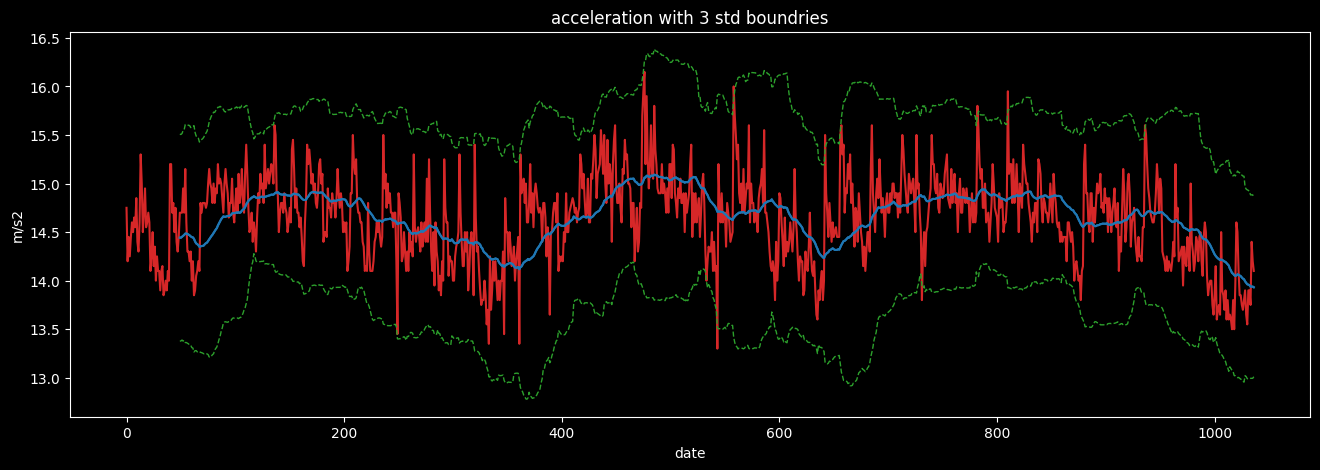

In [82]:
# plot them with boundries on top of 3 standard deviations
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_test.index, df_test["acceleration"], color="tab:red")
plt.plot(df_test.index, rolmean_df_test, color="tab:blue")
plt.plot(df_test.index, rolmean_df_test, color="tab:blue")
plt.plot(df_test.index, higher_bound, color="tab:green", ls="--", linewidth=1)
plt.plot(df_test.index, lower_bound, color="tab:green", ls="--", linewidth=1)
plt.plot
plt.gca().set(title="acceleration with 3 std boundries", xlabel="date", ylabel="m/s2")
plt.show()

# 2. Predict / Forecast

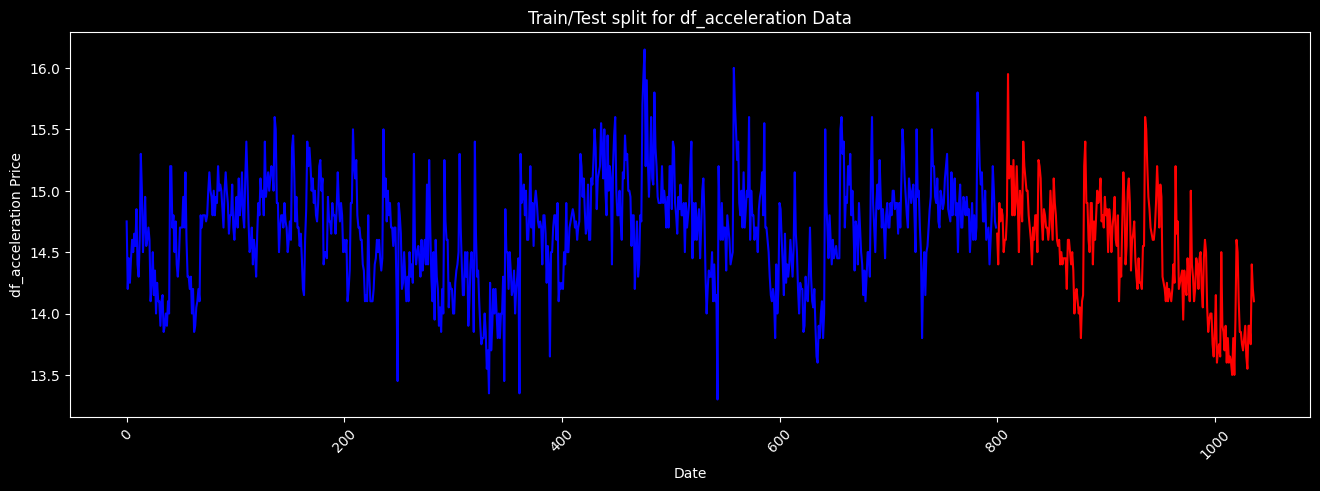

In [83]:
# Create a test and train sample
test_acceleration = df_test["acceleration"]
df_test_train = test_acceleration[test_acceleration.index < 800]
df_test_test = test_acceleration[test_acceleration.index >= 800]
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_test_train, color="blue")
plt.plot(df_test_test, color="red")
plt.ylabel("df_acceleration Price")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Train/Test split for df_acceleration Data")
plt.show()

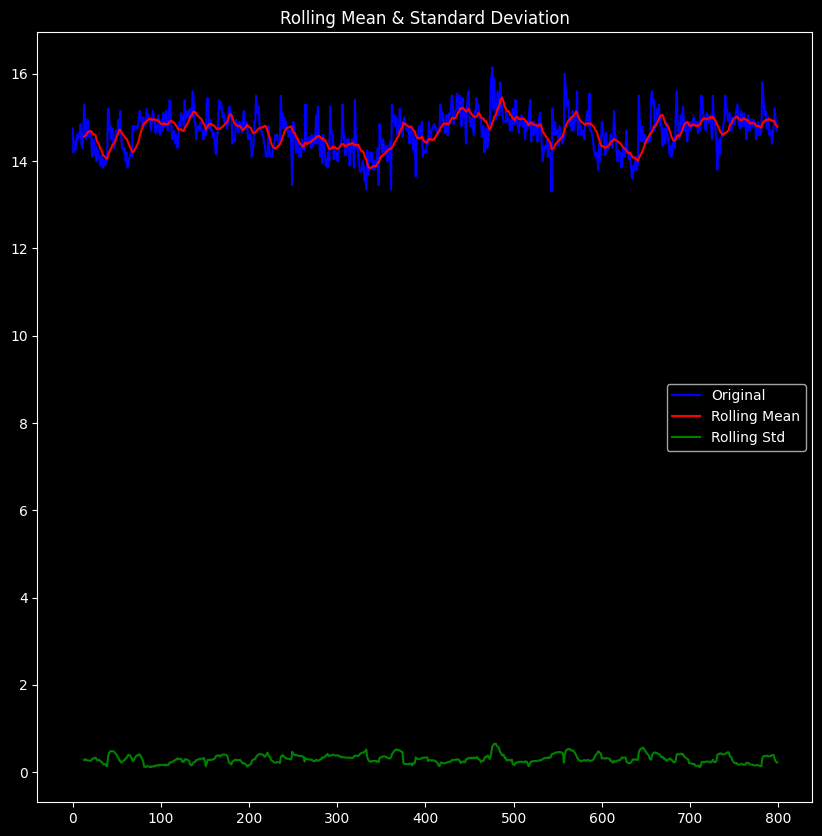

Results of Dickey-Fuller Test:
Test Statistic                  -4.224332
p-value                          0.000599
#Lags Used                      14.000000
Number of Observations Used    785.000000
Critical Value (1%)             -3.438708
Critical Value (5%)             -2.865229
Critical Value (10%)            -2.568734
dtype: float64


In [84]:
# decomposition = seasonal_decompose(df_test_train)
rolmean = df_test_train.rolling(14).mean()
rolstd = df_test_train.rolling(14).std()
# Plot rolling statistics:
plt.plot(df_test_train, color="blue", label="Original")
plt.plot(rolmean, color="red", label="Rolling Mean")
plt.plot(rolstd, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df_test_train, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)
# ITs stationary because
# • test statistic is lower than 1% critical values.

# • the mean and std variations have small variations with time.
# the p value is very low

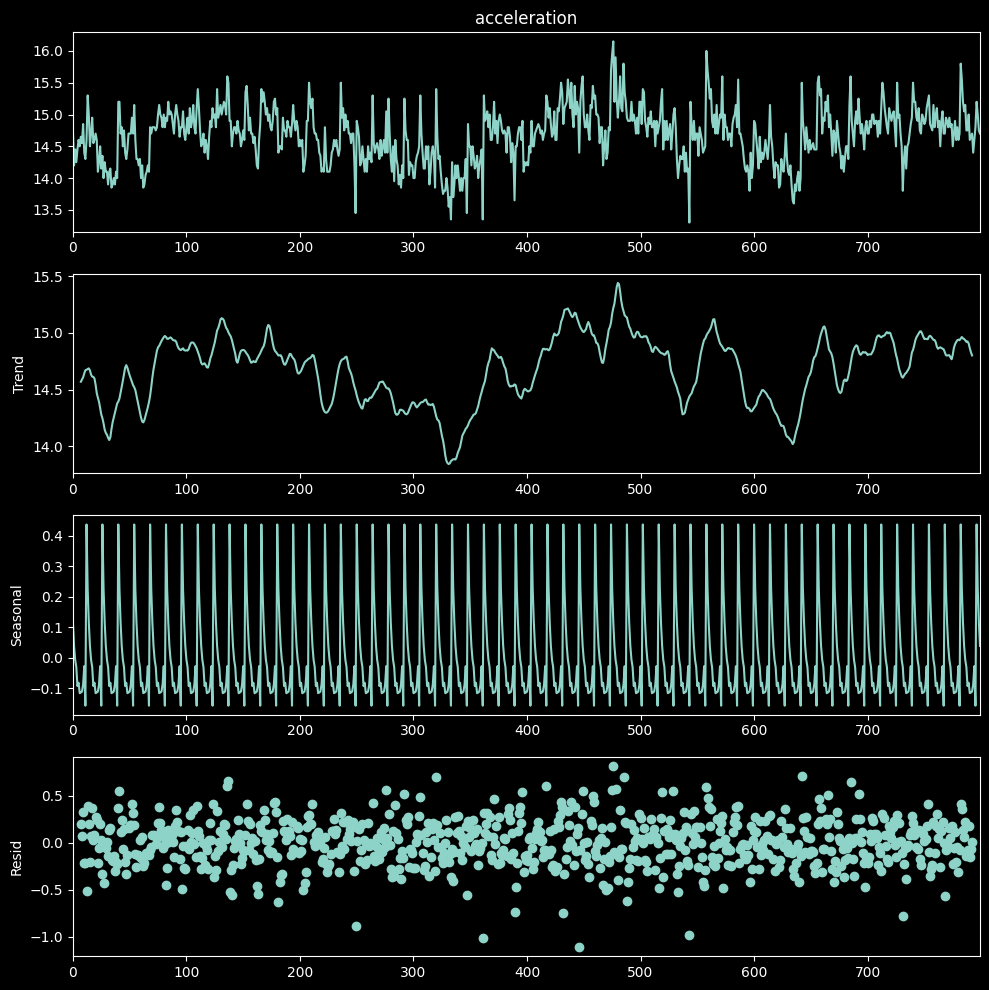

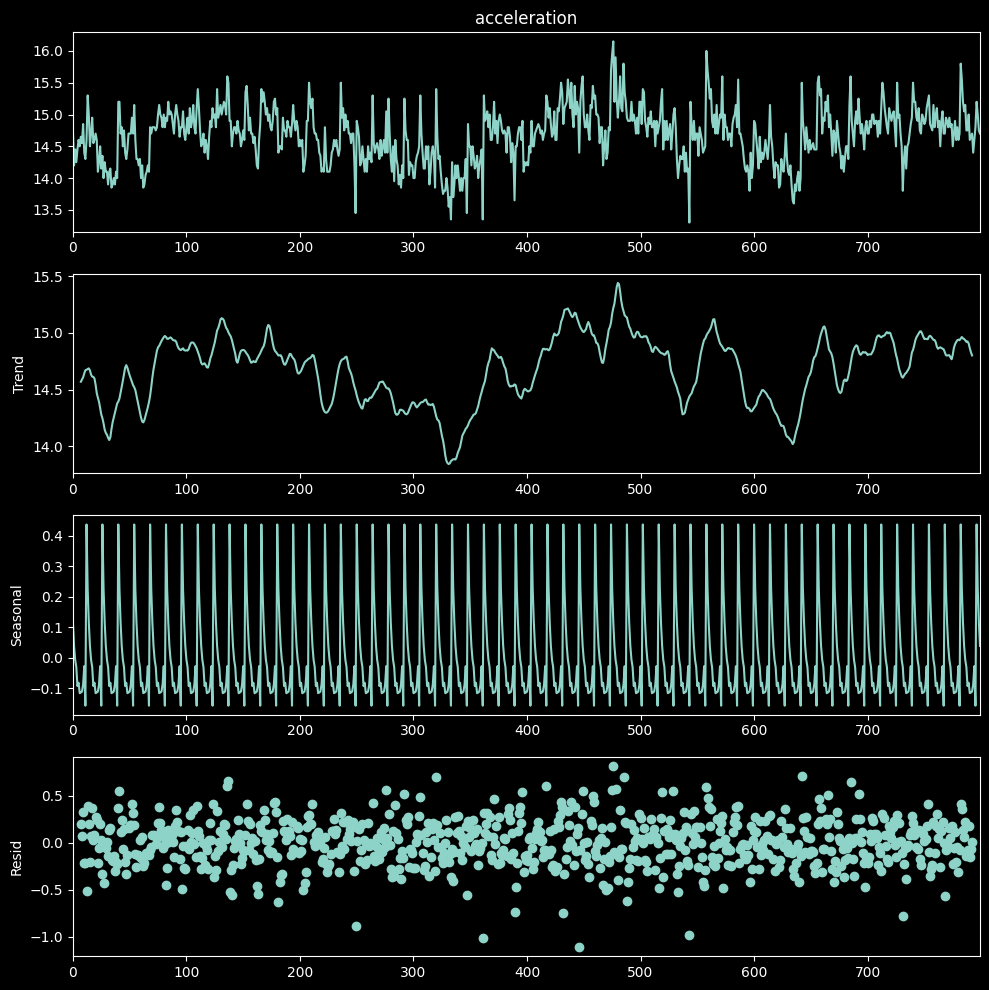

In [85]:
# If our line was not stationary we would decompose, but its not needed in this case
decomposition = seasonal_decompose(df_test_train, period=14)
decomposition.plot()

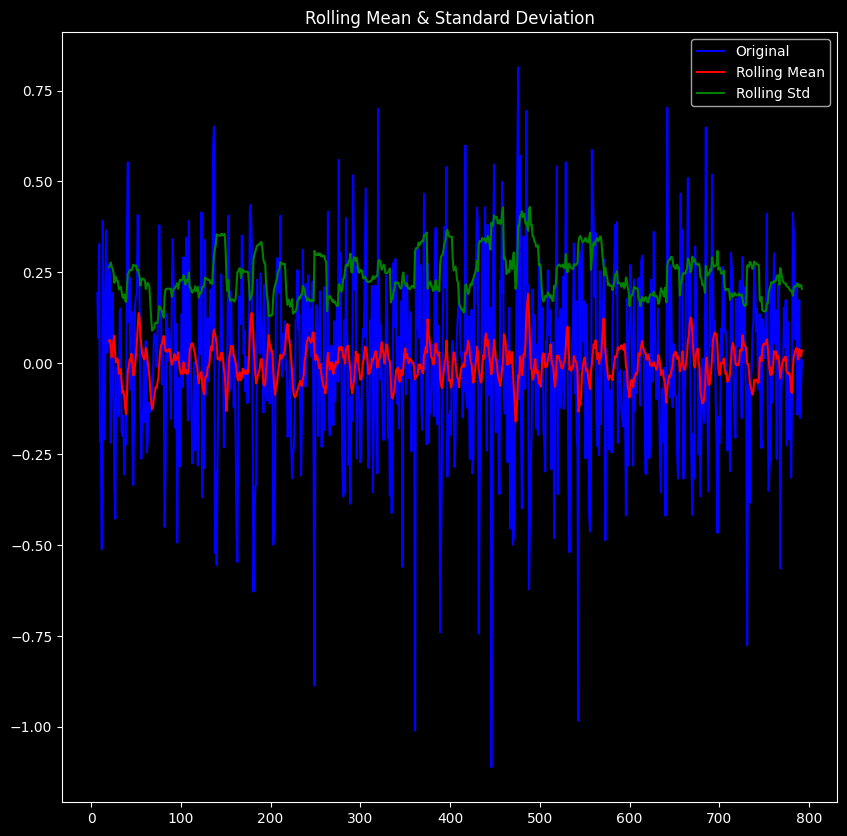

Results of Dickey-Fuller Test:
Test Statistic                -1.104545e+01
p-value                        5.237251e-20
#Lags Used                     1.900000e+01
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [86]:
# Lets use the residual
y_train_residual = decomposition.resid
y_train_residual.dropna(inplace=True)
rolmean = y_train_residual.rolling(14).mean()
rolstd = y_train_residual.rolling(14).std()
# Plot rolling statistics:
plt.plot(y_train_residual, color="blue", label="Original")
plt.plot(rolmean, color="red", label="Rolling Mean")
plt.plot(rolstd, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(y_train_residual, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

 Now that we have made the Time series stationary,
let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values .
 We will use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.
Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model.  
 • p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).  
• q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).  
• d :This is the number of differences or the number of non-seasonal differences .  
P = lags in the autoregressive model.  
D = differencing / integration order.  
Q =  moving average lags  

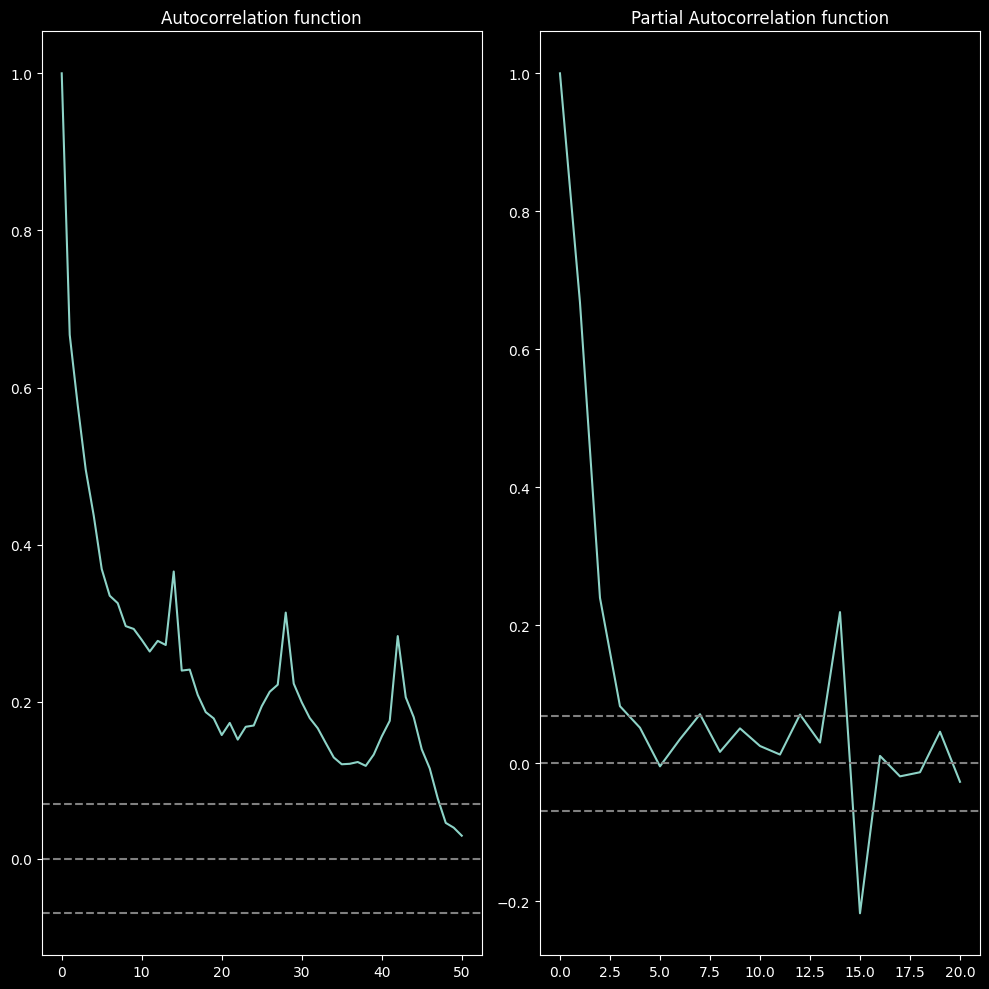

In [87]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_test_train, nlags=50)
lag_pacf = pacf(df_test_train, nlags=20)

# Plot
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, ls="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(df_test_train)), ls="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(df_test_train)), ls="--", color="gray")
plt.title("Autocorrelation function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, ls="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(df_test_train)), ls="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(df_test_train)), ls="--", color="gray")
plt.title("Partial Autocorrelation function")
plt.tight_layout()
# • p: The first time where the PACF crosses the upper confidence interval,

# • q: The first time where the ACF crosses the upper confidence interval

d:\Python\General\03_Projects\timeseries_iot\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


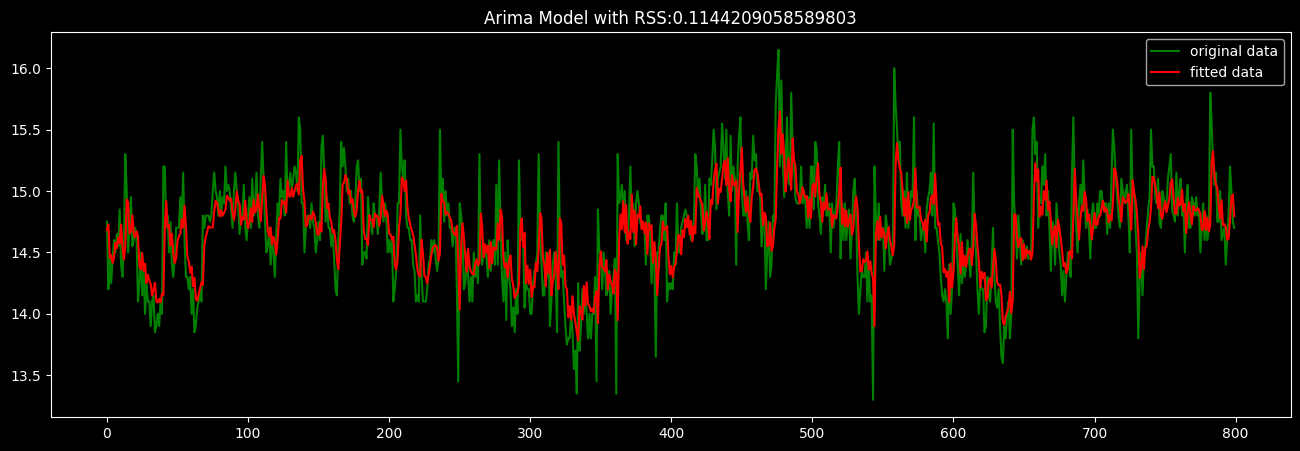

In [88]:
model = ARIMA(df_test_train, order=(3, 0, 3))
results_ARIMA = model.fit()
plt.figure(figsize=(16, 5))
plt.plot(df_test_train, color="green", label="original data")
plt.plot(results_ARIMA.fittedvalues, color="red", label="fitted data")
plt.title(f"Arima Model with RSS:{sum(results_ARIMA.fittedvalues-df_test_train)**2}")
plt.legend()
plt.show()

In [89]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           acceleration   No. Observations:                  800
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -182.849
Date:                Wed, 30 Nov 2022   AIC                            381.698
Time:                        15:48:05   BIC                            419.175
Sample:                             0   HQIC                           396.095
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6834      0.094    155.916      0.000      14.499      14.868
ar.L1          0.7297      0.090      8.111      0.000       0.553       0.906
ar.L2          0.9876      0.011     86.406      0.000       0.965       1.010
ar.L3         -0.7273      0.085     -8.592      0.000      -0.893      -0.561
ma.L1         -0.2449      0.100     -2.460      0.014      -0.440      -0.050
ma.L2         -0.9430      0.033    -28.402      0.000      -1.008      -0.878
ma.L3          0.2694      0.073      3.683      0.000       0.126       0.413
sigma2         0.0924      0.004     24.908      0.000       0.085       0.100
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               368.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.86
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
# Predict with the test set
prediction = results_ARIMA.get_forecast(len(df_test_test.index))
prediction_df = prediction.conf_int(alpha=0.05)
prediction_df["Predictions"] = results_ARIMA.predict(
    start=prediction_df.index[0], end=prediction_df.index[-1]
)
prediction_df.index = df_test_test.index
prediction_out = prediction_df["Predictions"]
arma_rmse = np.sqrt(
    mean_squared_error(df_test_test.values, prediction_df["Predictions"])
)
print("RMSE: ", arma_rmse)

RMSE:  0.4878083216720913


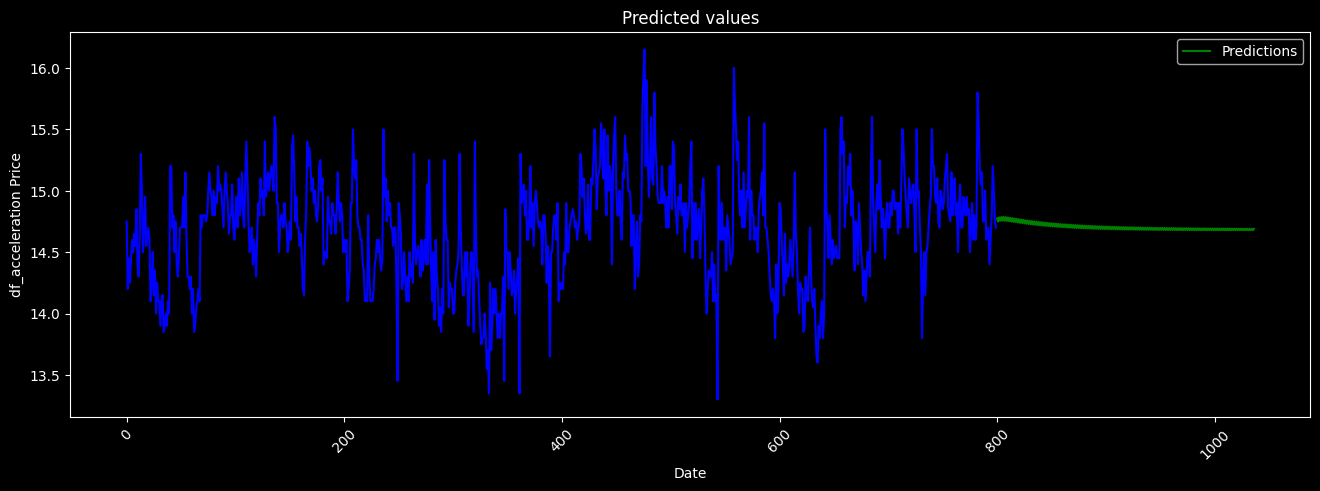

In [91]:
# Plot
plt.figure(figsize=(16, 5))
plt.plot(prediction_out, color="green", label="Predictions")
plt.plot(df_test_train, color="blue")
# plt.plot(df_test_test, color = "red")
plt.ylabel("df_acceleration Price")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("Predicted values")
plt.legend()

###  Predictions with Sarimax

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# y=df_hour['acceleration']
y = df_test_train
ARMAmodel = SARIMAX(y, order=(2, 0, 1))  # seasonal_order=(1,1,1,14))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(df_test_test.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(
    start=y_pred_df.index[0], end=y_pred_df.index[-1]
)
y_pred_df.index = df_test_test.index
y_pred_out = y_pred_df["Predictions"]
arma_rmse = np.sqrt(mean_squared_error(df_test_test.values, y_pred_df["Predictions"]))
print("RMSE: ", arma_rmse)

RMSE:  0.4263785285658463


Text(0.5, 1.0, 'Sarima model on train/validate data')

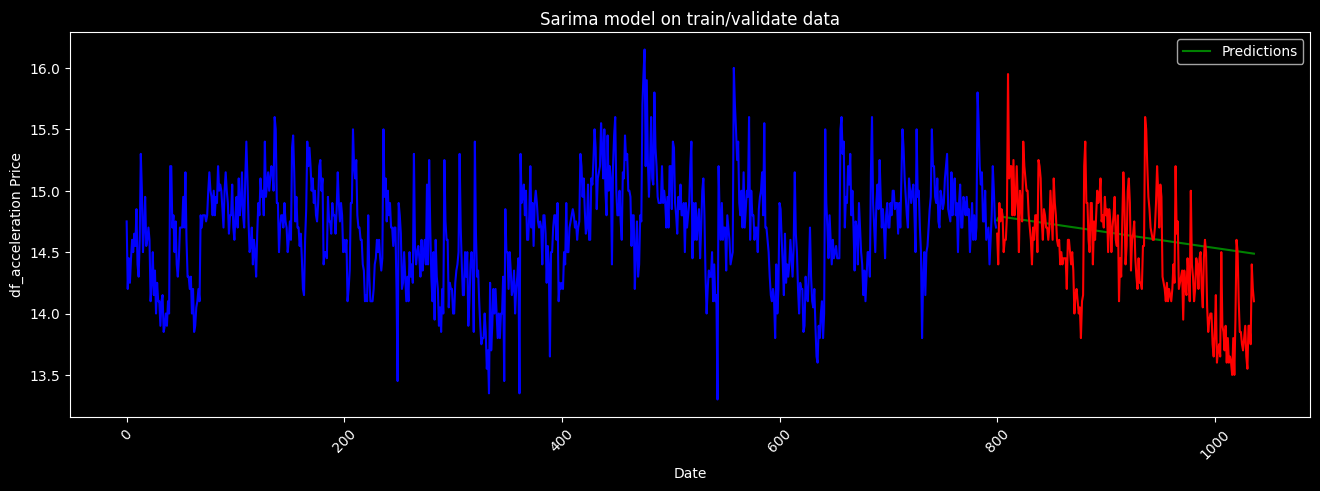

In [93]:
# Draw prediction
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(y_pred_out, color="green", label="Predictions")
plt.plot(df_test_train, color="blue")
plt.plot(df_test_test, color="red")
plt.ylabel("df_acceleration Price")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.title("Sarima model on train/validate data")

d:\Python\General\03_Projects\timeseries_iot\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Sarima predictions with RSS:0.12823794971601005')

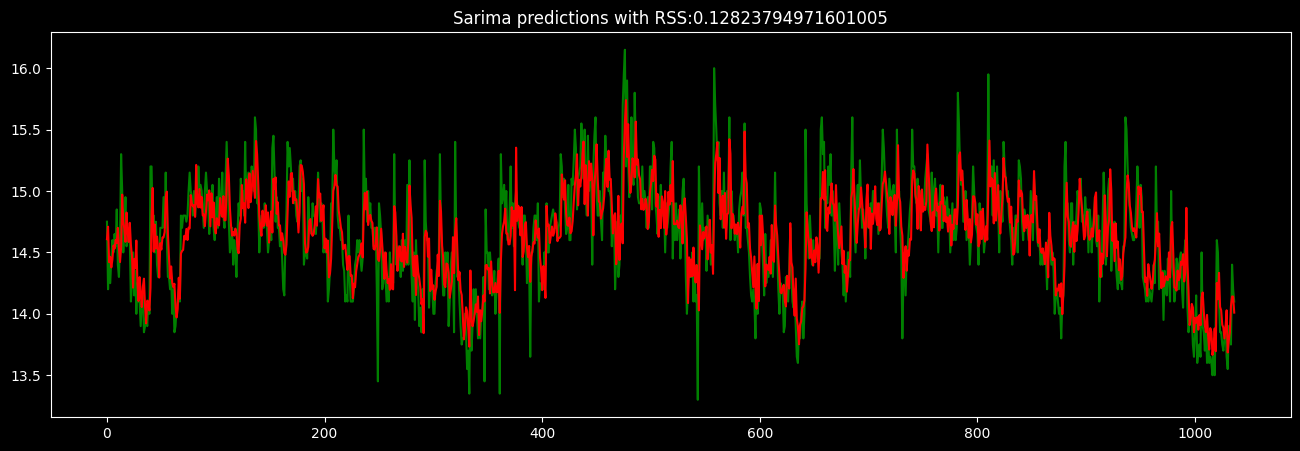

In [94]:
# We use our real data now
df_hour_reset_index = df_hour_filtered.copy()
df_hour_reset_index.reset_index(inplace=True)
model = ARIMA(df_hour_reset_index["acceleration"], order=(45, 0, 3))
ARIMA_model = model.fit()
plt.figure(figsize=(16, 5))
plt.plot(df_hour_reset_index["acceleration"], color="green")
plt.plot(ARIMA_model.fittedvalues, color="red")
plt.title(
    f"Sarima predictions with RSS:{sum(ARIMA_model.fittedvalues-df_hour_reset_index['acceleration'])**2}"
)

In [95]:
prediction = ARIMA_model.get_forecast(100)
prediction_df = prediction.conf_int(alpha=0.05)
prediction_df["predictions"] = ARIMA_model.predict(
    start=prediction_df.index[0], end=prediction_df.index[-1]
)
prediction_df.index = pd.RangeIndex(
    start=df_hour_reset_index.index[-1],
    stop=df_hour_reset_index.index[-1] + 100,
    step=1,
)
prediction_out = prediction_df["predictions"]

Text(0.5, 1.0, 'Forecast for 100 values')

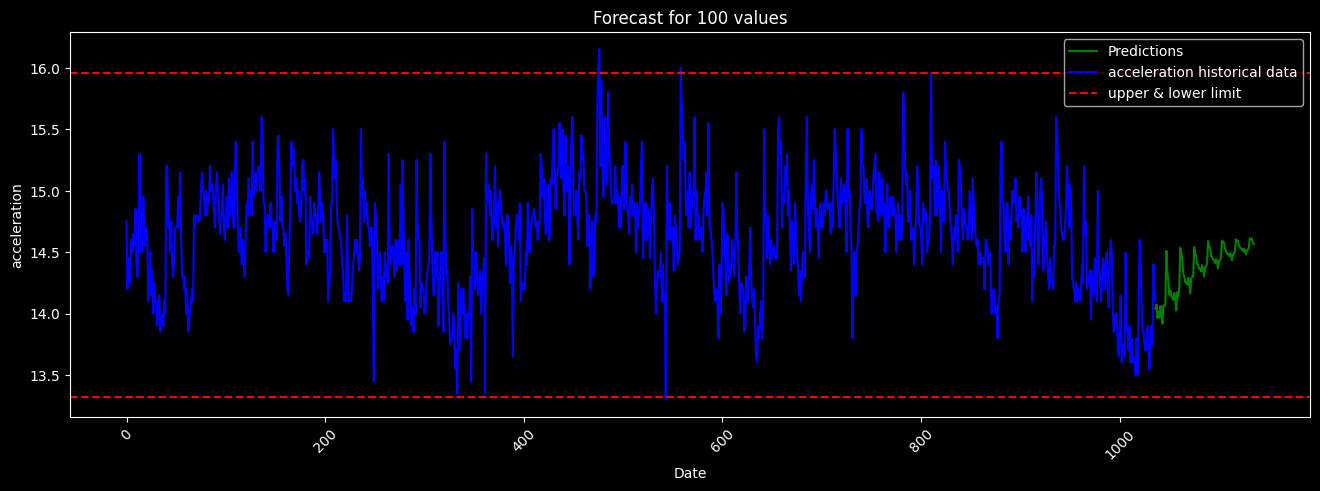

In [96]:
# Plot
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(prediction_out, color="green", label="Predictions")
plt.plot(
    df_hour_reset_index["acceleration"],
    color="blue",
    label="acceleration historical data",
)
plt.axhline(
    y=df_hour_reset_index["acceleration"].mean()
    + 3 * df_hour_reset_index["acceleration"].std(),
    color="red",
    ls="--",
    label="upper & lower limit",
)
plt.axhline(
    y=df_hour_reset_index["acceleration"].mean()
    - 3 * df_hour_reset_index["acceleration"].std(),
    color="red",
    ls="--",
)
# plt.plot(df_test_test, color = "red")
plt.ylabel("acceleration")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.title("Forecast for 100 values")

#### Bring back original datetime index

In [97]:
df_hour_reset_index.set_index("Time", inplace=True)
df_hour_reset_index
ts = pd.date_range("2022-06-09 09:00:00", freq="H", periods=100)

In [98]:
predictions_date = prediction_out.copy()

In [99]:
# predictions_date = pd.concat([predictions_date,ts])
predictions_date = predictions_date.to_frame()

In [100]:
predictions_date.set_index(ts, inplace=True)

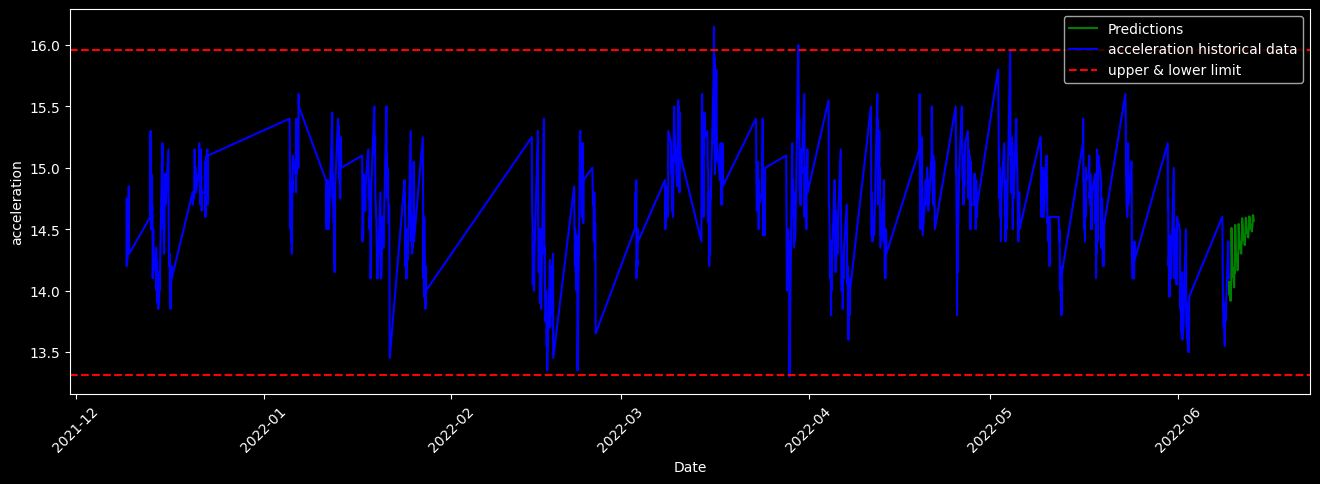

In [101]:
# Plot
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(predictions_date, color="green", label="Predictions")
plt.plot(
    df_hour_reset_index["acceleration"],
    color="blue",
    label="acceleration historical data",
)
plt.axhline(
    y=df_hour_reset_index["acceleration"].mean()
    + 3 * df_hour_reset_index["acceleration"].std(),
    color="red",
    ls="--",
    label="upper & lower limit",
)
plt.axhline(
    y=df_hour_reset_index["acceleration"].mean()
    - 3 * df_hour_reset_index["acceleration"].std(),
    color="red",
    ls="--",
)
# plt.plot(df_test_test, color = "red")
plt.ylabel("acceleration")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()

## We will use now our ARIMA and SARIMA and train on the complete dataset

In [102]:
from pandas.tseries.offsets import DateOffset

In [103]:
# Do the same but just setting the index
df_string = df_hour_filtered.copy()
df_string.index = df_string.index.strftime("%m/%d/%Y, %H")

In [104]:
rolmean_df_string = df_string["acceleration"].rolling(50).mean()
rolstd_df_string = df_string["acceleration"].rolling(50).std()
higher_bound = rolmean_df_string + 3 * rolstd_df_string
lower_bound = rolmean_df_string - 3 * rolstd_df_string

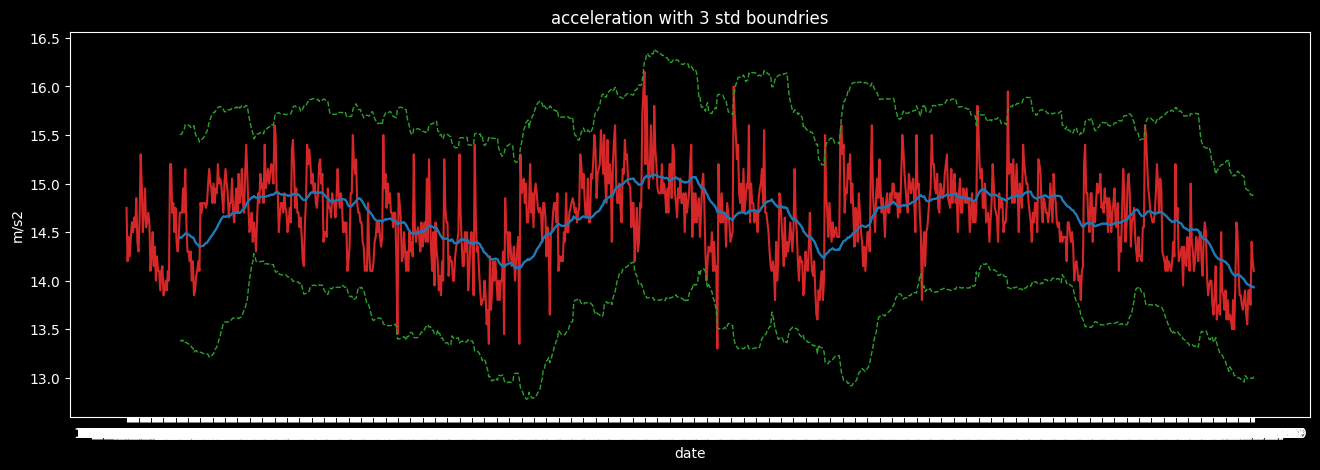

In [105]:
# plot them with boundries on top of 3 standard deviations
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_string.index, df_string["acceleration"], color="tab:red")
plt.plot(df_string.index, rolmean_df_string, color="tab:blue")
plt.plot(df_string.index, rolmean_df_string, color="tab:blue")
plt.plot(df_string.index, higher_bound, color="tab:green", ls="--", linewidth=1)
plt.plot(df_string.index, lower_bound, color="tab:green", ls="--", linewidth=1)
plt.plot
plt.gca().set(title="acceleration with 3 std boundries", xlabel="date", ylabel="m/s2")
plt.show()

### Strategy
The idea is the following: lets use daily values to spot trends. Lets take means or median of day values. And the days that have 0 lets give them the same value as the previous day. And try to predict from there

In [106]:
# Do test but with day values
# lets try filtering out cero values in advance
df_filtered = df[df["acceleration"] > 10]
df_day = df_filtered.resample("d").mean()
df_day["weekday"] = [d.strftime("%a") for d in df_day.index]
df_day["day"] = [d.strftime("%H") for d in df_day.index]
df_day["yearweek"] = [d.strftime("%W") for d in df_day.index]
df_day["month"] = [d.strftime("%b") for d in df_day.index]
df_day["yearday"] = [d.strftime("%j") for d in df_day.index]
df_day["year"] = [d.strftime("%Y") for d in df_day.index]
df_day["day"] = df_day["day"].astype(int)

In [107]:
df_day["acceleration"].isnull().values.sum()

71

In [108]:
# Explore weekends
weekends_perday = df_day[df_day["weekday"].isin(["Sat", "Sun"])]

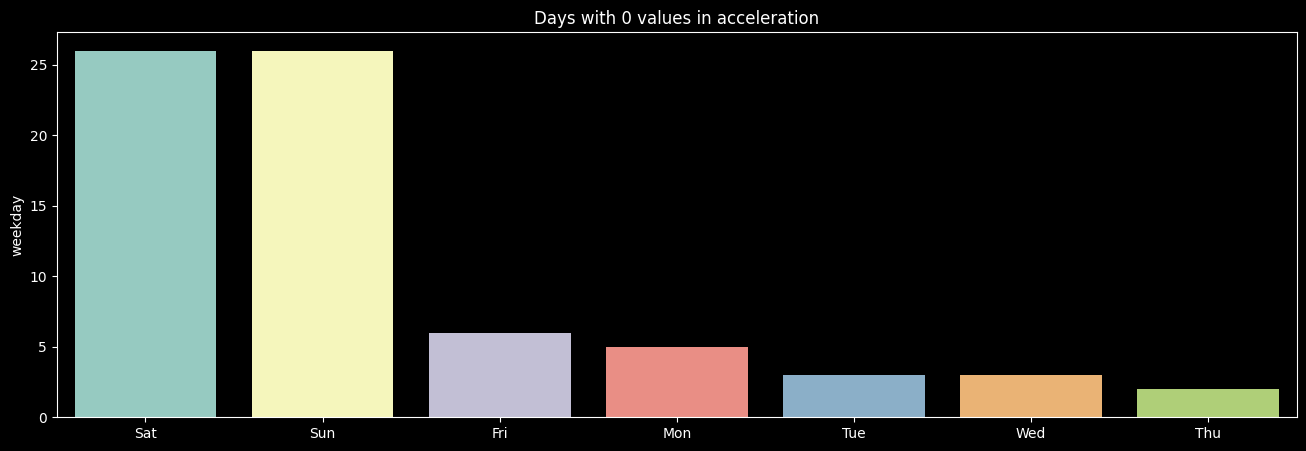

In [109]:
# Lets Check the emtpy values
empty_list = df_day[df_day["acceleration"].isnull()]
y = empty_list["weekday"].value_counts()
x = empty_list["weekday"].unique()
plt.figure(figsize=(16, 5), dpi=100)
sns.barplot(x=x, y=y)
plt.title("Days with 0 values in acceleration")
plt.show()

In [110]:
df_day["acceleration"]

Time
2021-12-09    14.614485
2021-12-10    14.880271
2021-12-11          NaN
2021-12-12          NaN
2021-12-13    14.618548
                ...    
2022-06-05          NaN
2022-06-06          NaN
2022-06-07    14.468826
2022-06-08    14.100000
2022-06-09    14.437168
Freq: D, Name: acceleration, Length: 183, dtype: float32

In [111]:
df_day_filled = df_day["acceleration"].fillna(method="ffill")

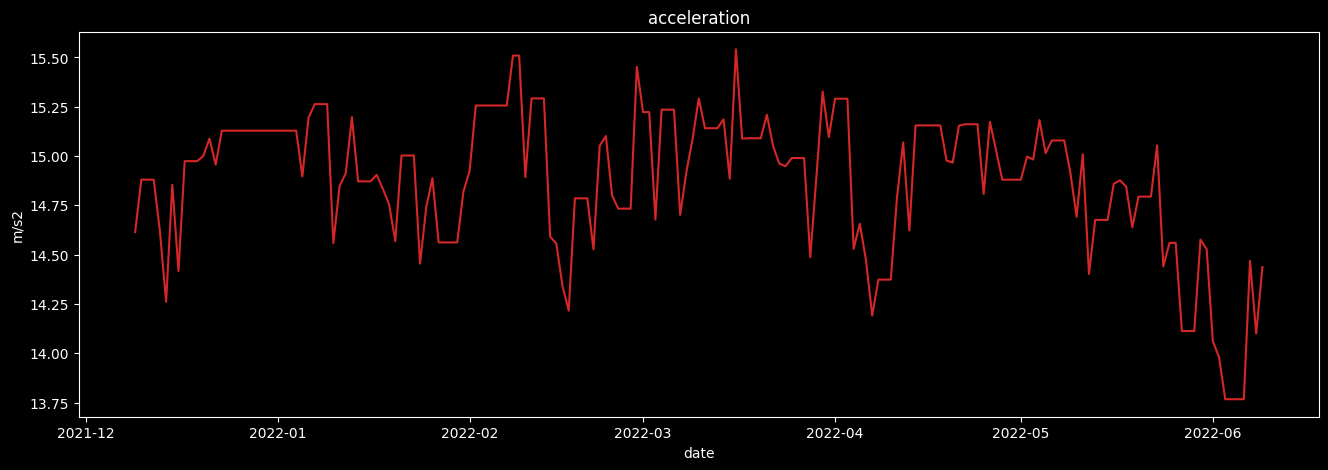

In [112]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_day_filled.index, df_day_filled, color="tab:red")
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title="acceleration", xlabel="date", ylabel="m/s2")
plt.show()

In [113]:
df_day_filtered = df_day[df_day["acceleration"] > 8]

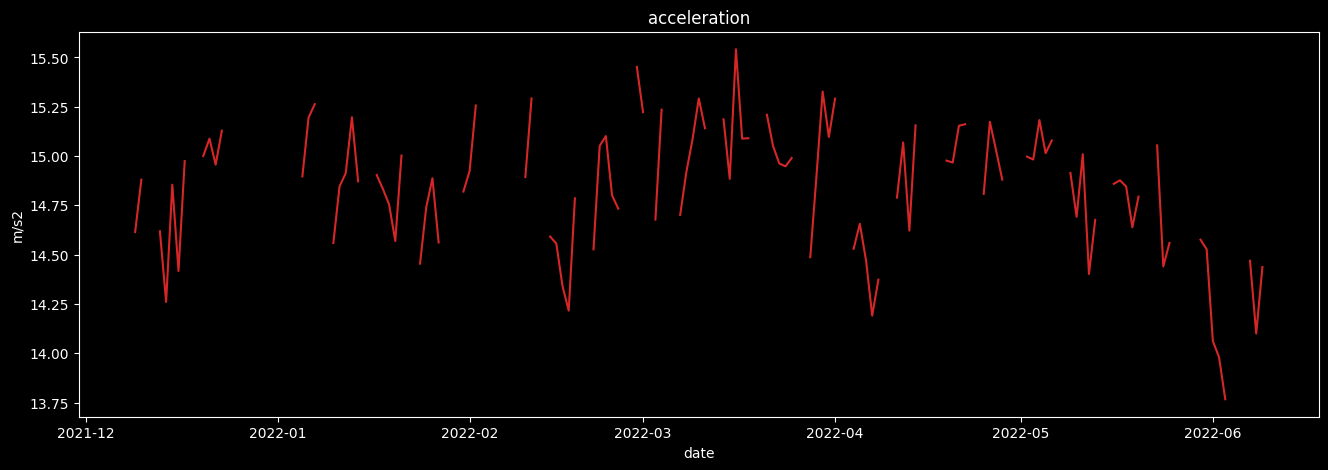

In [114]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_day.index, df_day["acceleration"], color="tab:red")
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title="acceleration", xlabel="date", ylabel="m/s2")
plt.show()

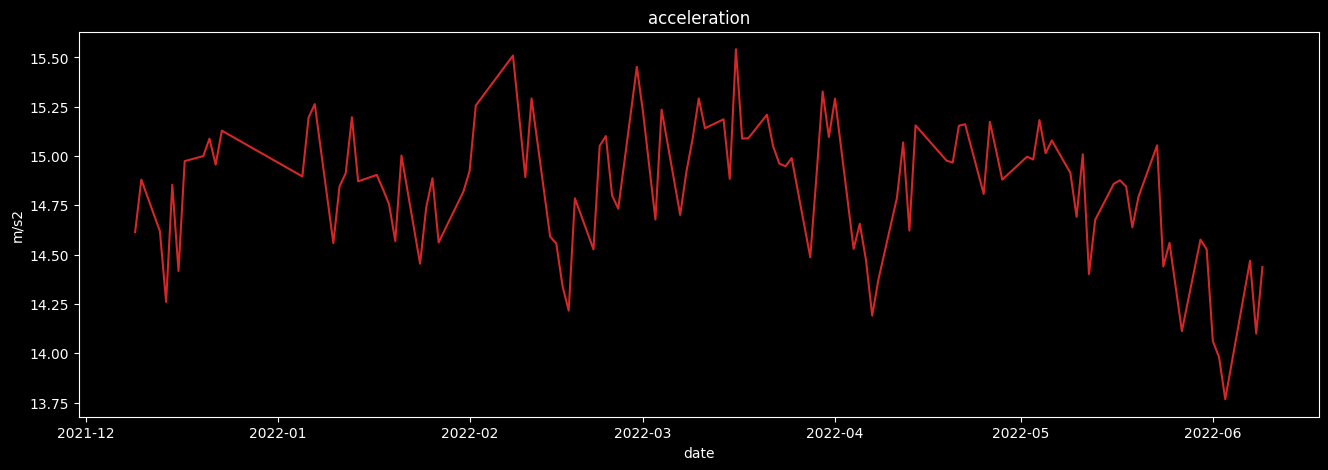

In [115]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(df_day_filtered.index, df_day_filtered["acceleration"], color="tab:red")
# plt.axhline(y=[18], color='green', ls='--', lw=2, label='vline_multiple - full height')
plt.gca().set(title="acceleration", xlabel="date", ylabel="m/s2")
plt.show()

Text(0.5, 0.98, 'Decomposition')

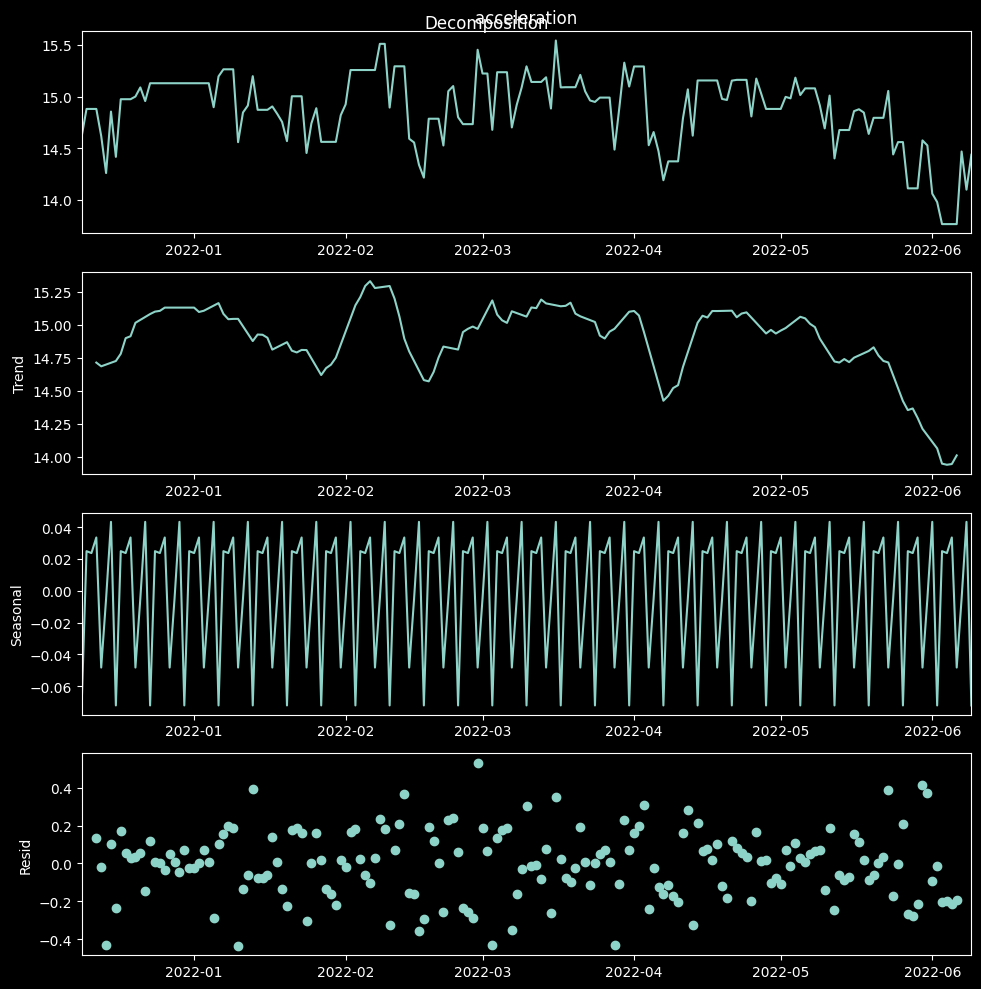

In [116]:
decomposition = seasonal_decompose(df_day_filled)
day_trend = decomposition.trend
day_seasonal = decomposition.seasonal
day_residual = decomposition.resid
decomposition.plot().suptitle("Decomposition")

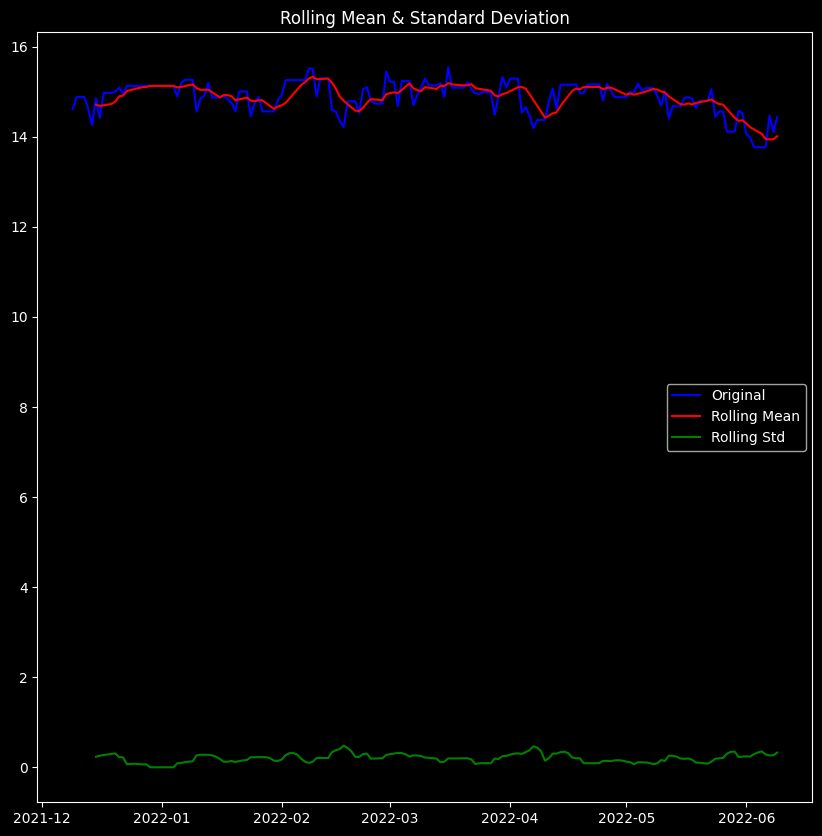

Results of Dickey-Fuller Test:
Test Statistic                  -3.736106
p-value                          0.003633
#Lags Used                       1.000000
Number of Observations Used    181.000000
Critical Value (1%)             -3.467005
Critical Value (5%)             -2.877644
Critical Value (10%)            -2.575355
dtype: float64


In [117]:
# Lets check for stationarity with our data series
rolmean_day = df_day_filled.rolling(7).mean()
rolstd_day = df_day_filled.rolling(7).std()
# Plot rolling statistics:
plt.plot(df_day_filled, color="blue", label="Original")
plt.plot(rolmean_day, color="red", label="Rolling Mean")
plt.plot(rolstd_day, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df_day_filled, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

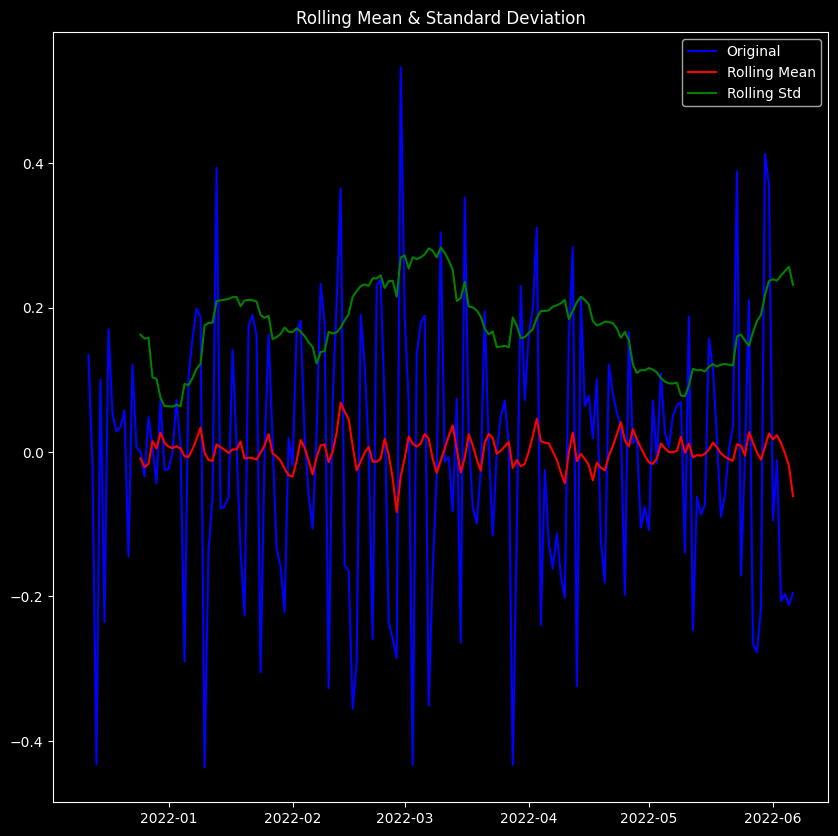

Results of Dickey-Fuller Test:
Test Statistic                -6.277101e+00
p-value                        3.876537e-08
#Lags Used                     1.300000e+01
Number of Observations Used    1.630000e+02
Critical Value (1%)           -3.471119e+00
Critical Value (5%)           -2.879441e+00
Critical Value (10%)          -2.576314e+00
dtype: float64


In [118]:
# Lets use the residual
day_residual.dropna(inplace=True)
rolmean = day_residual.rolling(14).mean()
rolstd = day_residual.rolling(14).std()
# Plot rolling statistics:
plt.plot(day_residual, color="blue", label="Original")
plt.plot(rolmean, color="red", label="Rolling Mean")
plt.plot(rolstd, color="green", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()
# Perform Dickey-Fuller test:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(day_residual, autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"],
)
for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

Lets do forecasting for original series and for the rolling mean

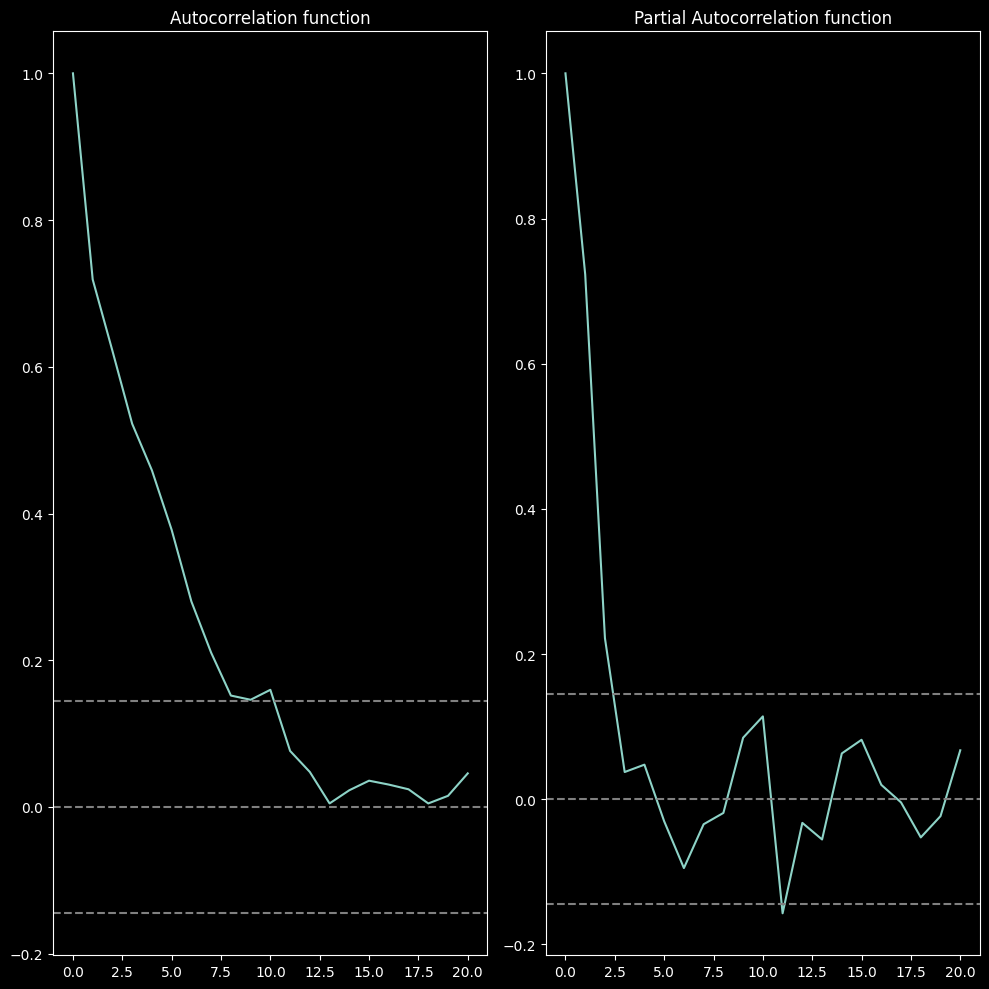

In [119]:
lag_acf = acf(df_day_filled, nlags=20)
lag_pacf = pacf(df_day_filled, nlags=20)

# Plot
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, ls="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(df_day_filled)), ls="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(df_day_filled)), ls="--", color="gray")
plt.title("Autocorrelation function")

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, ls="--", color="gray")
plt.axhline(y=-1.96 / np.sqrt(len(df_day_filled)), ls="--", color="gray")
plt.axhline(y=1.96 / np.sqrt(len(df_day_filled)), ls="--", color="gray")
plt.title("Partial Autocorrelation function")
plt.tight_layout()

d:\Python\General\03_Projects\timeseries_iot\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS:0.014935298376430893')

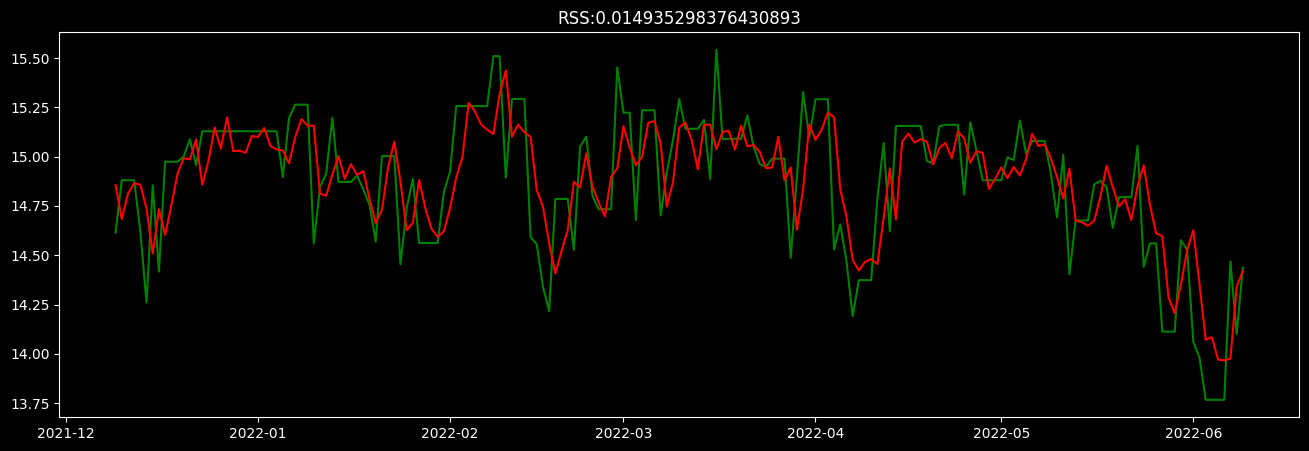

In [120]:
model = ARIMA(df_day_filled, order=(12, 0, 3))
ARIMA_model = model.fit()
plt.figure(figsize=(16, 5))
plt.plot(df_day_filled, color="green")
plt.plot(ARIMA_model.fittedvalues, color="red")
plt.title(f"RSS:{sum(ARIMA_model.fittedvalues-df_day_filled)**2}")

Text(0.5, 1.0, 'Sarima,RSS:183.2162004912324')

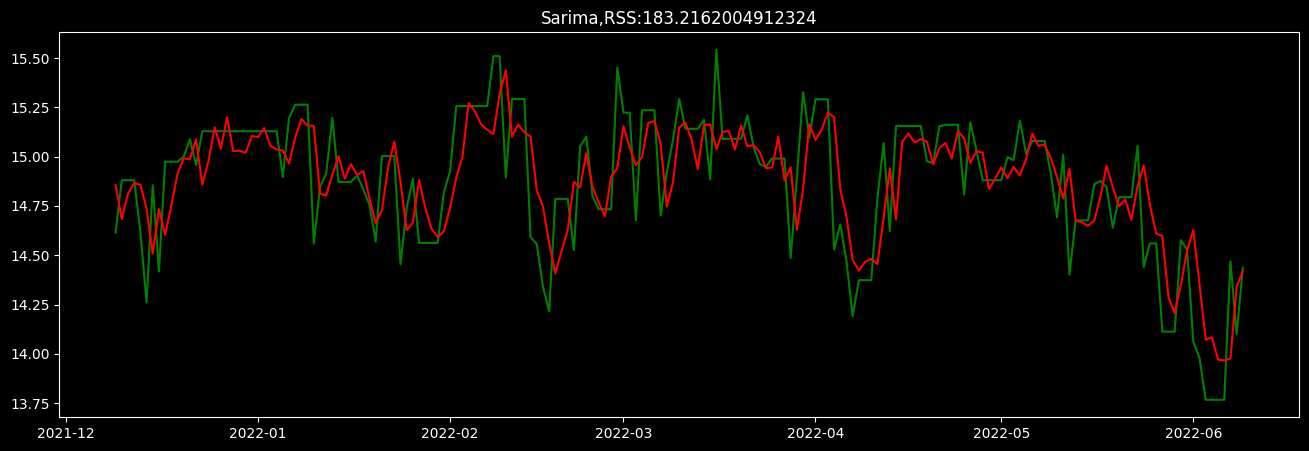

In [121]:
model = SARIMAX(df_day_filled, order=(1, 1, 1), seasonal_order=(1, 0, 0, 7))
SARIMA_model = model.fit()
plt.figure(figsize=(16, 5))
plt.plot(df_day_filled, color="green")
plt.plot(ARIMA_model.fittedvalues, color="red")
plt.title(f"Sarima,RSS:{sum(SARIMA_model.fittedvalues-df_day_filled)**2}")

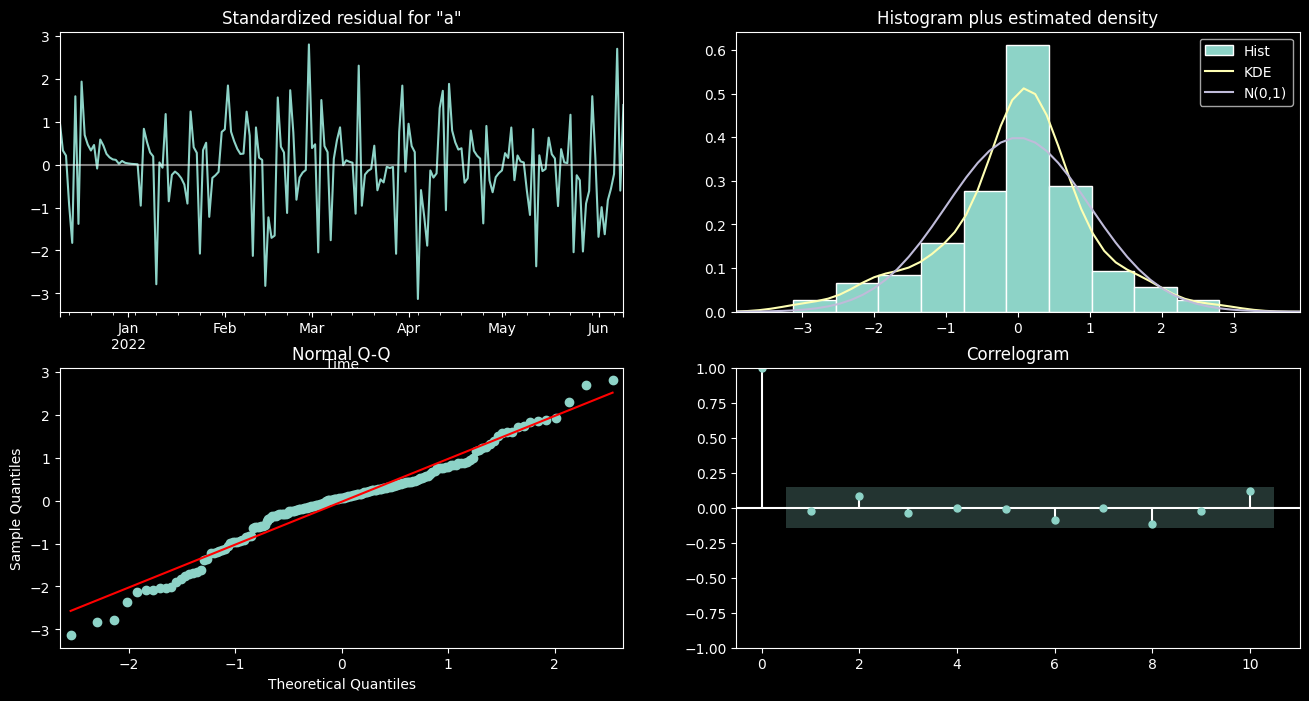

In [122]:
SARIMA_model.plot_diagnostics(figsize=(16, 8))
plt.show()

Text(0.5, 1.0, 'Exponential Smoothing 1.0664603533493982e-08')

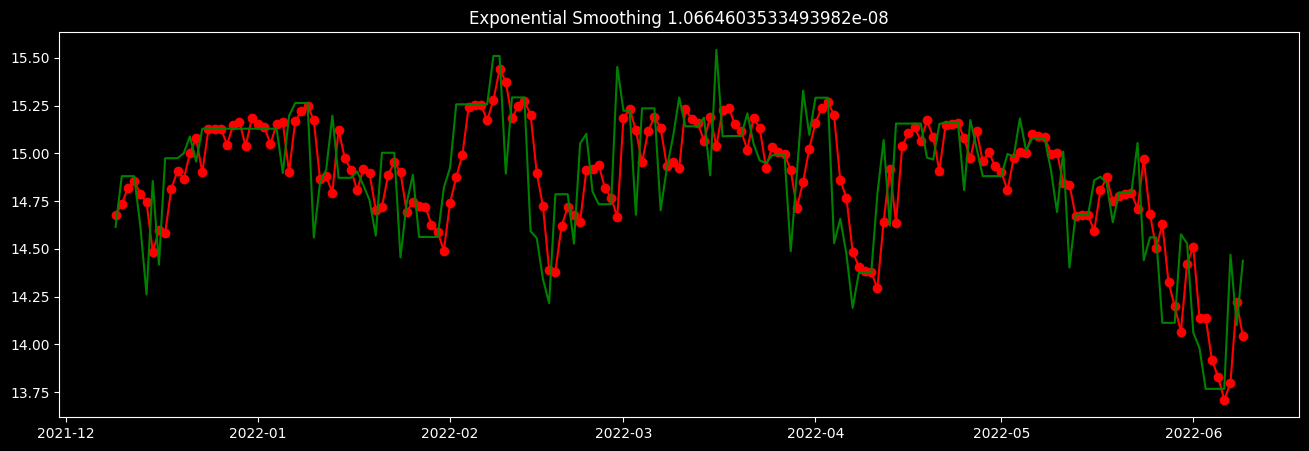

In [123]:
# Try exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing

exp_smoothing_model = ExponentialSmoothing(
    df_day_filled, trend="add", seasonal="add"
).fit()
fcast1 = exp_smoothing_model.forecast(100).rename("Additive")
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(exp_smoothing_model.fittedvalues, marker="o", color="red")
plt.plot(df_day_filled, color="green")
plt.title(
    f"Exponential Smoothing {sum(exp_smoothing_model.fittedvalues-df_day_filled)**2}"
)
# mse1 = ((fcast1 - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of additive trend, additive seasonal of '+
#         'period season_length={} and a Box-Cox transformation {}'.format(7,round(np.sqrt(mse1), 2)))

Text(0.5, 1.0, 'Holt Method 0.07010156813241154')

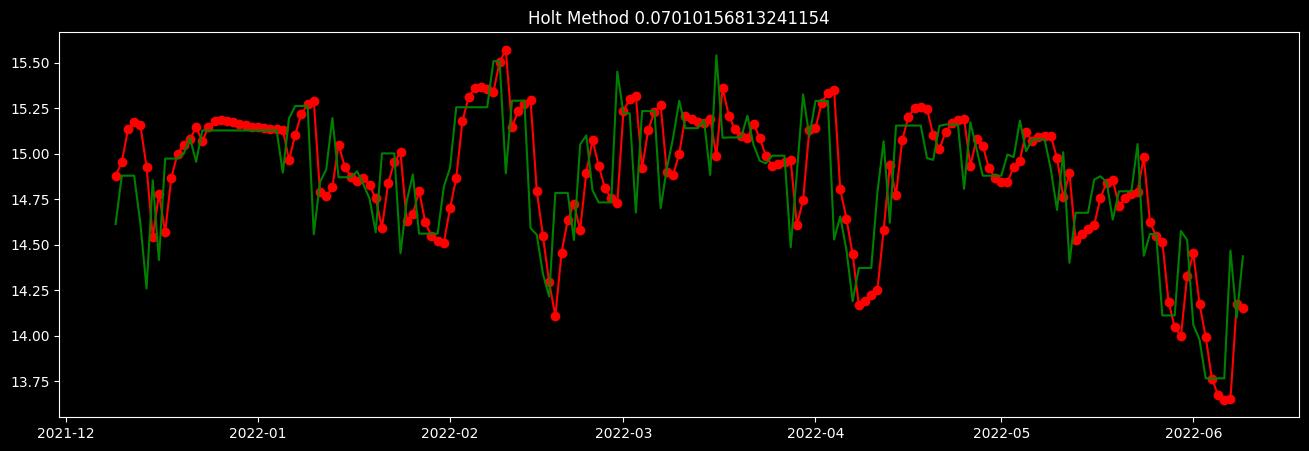

In [124]:
# Try Holt
from statsmodels.tsa.api import Holt

smoothing_level = 0.6
smoothing_slope = 0.2
holt_model = Holt(df_day_filled).fit(smoothing_level, smoothing_slope, optimized=False)
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(holt_model.fittedvalues, marker="o", color="red")
plt.plot(df_day_filled, color="green")
plt.title(f"Holt Method {((holt_model.fittedvalues-df_day_filled)**2).mean()}")

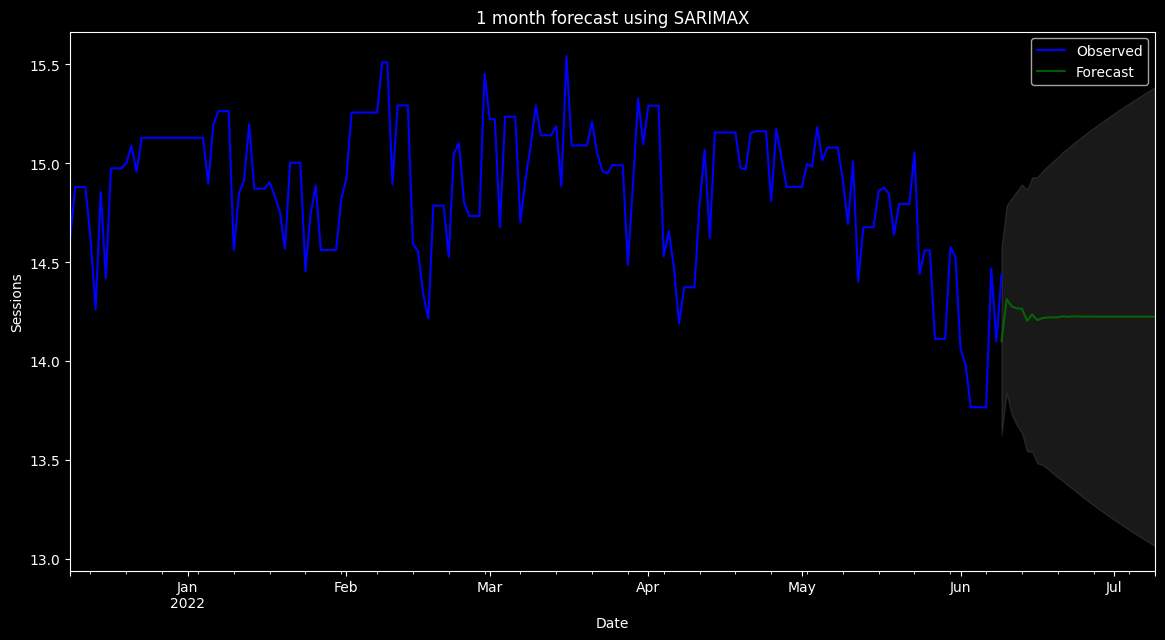

In [125]:
pred = SARIMA_model.get_prediction(
    start=df_day_filled.index[-1],
    end=df_day_filled.index[-1] + DateOffset(months=1),
    dynamic=False,
)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
# mse = ((y_forecasted - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(7,round(np.sqrt(mse), 2)))
y = df_day_filled
ax = y.plot(label="Observed", color="blue")
y_forecasted.plot(ax=ax, label="Forecast", alpha=0.7, figsize=(14, 7), color="green")
ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="grey", alpha=0.2
)

ax.set_xlabel("Date")
ax.set_ylabel("Sessions")
plt.legend()
plt.title("1 month forecast using SARIMAX")
plt.show()

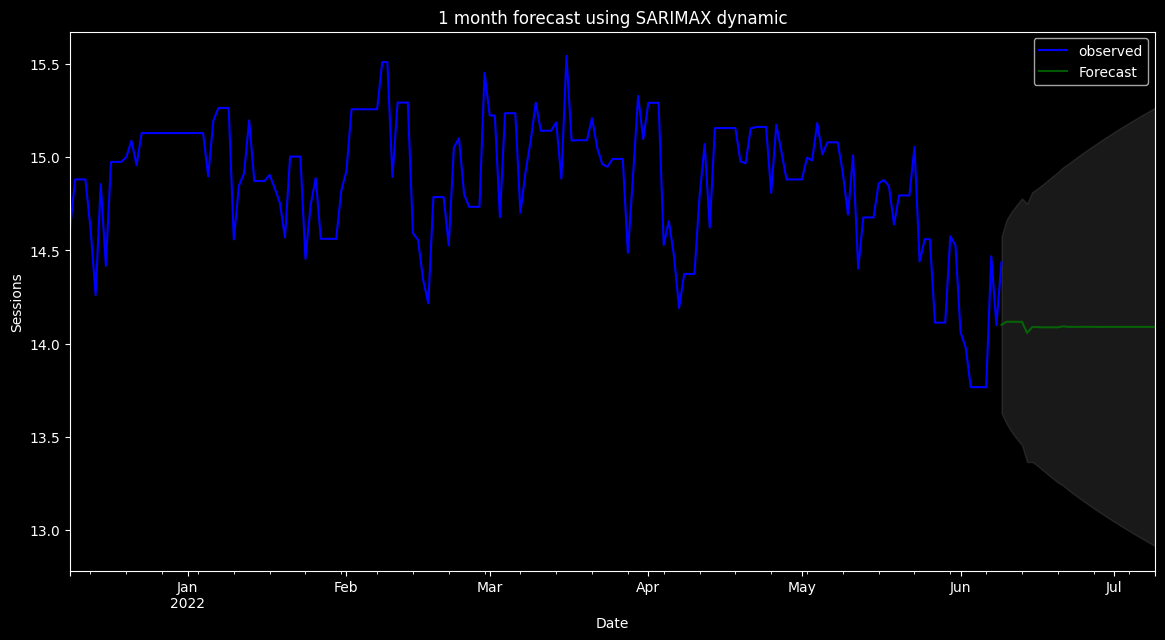

In [126]:
pred = SARIMA_model.get_prediction(
    start=df_day_filled.index[-1],
    end=df_day_filled.index[-1] + DateOffset(months=1),
    dynamic=True,
    full_results=True,
)
pred_ci = pred.conf_int()
y_forecasted = pred.predicted_mean
# mse = ((y_forecasted - y_to_test) ** 2).mean()
# print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(7,round(np.sqrt(mse), 2)))
y = df_day_filled
ax = y.plot(label="observed", color="b")
y_forecasted.plot(ax=ax, label="Forecast", alpha=0.7, figsize=(14, 7), color="g")
ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="grey", alpha=0.2
)

ax.set_xlabel("Date")
ax.set_ylabel("Sessions")
plt.legend()
plt.title("1 month forecast using SARIMAX dynamic")
plt.show()

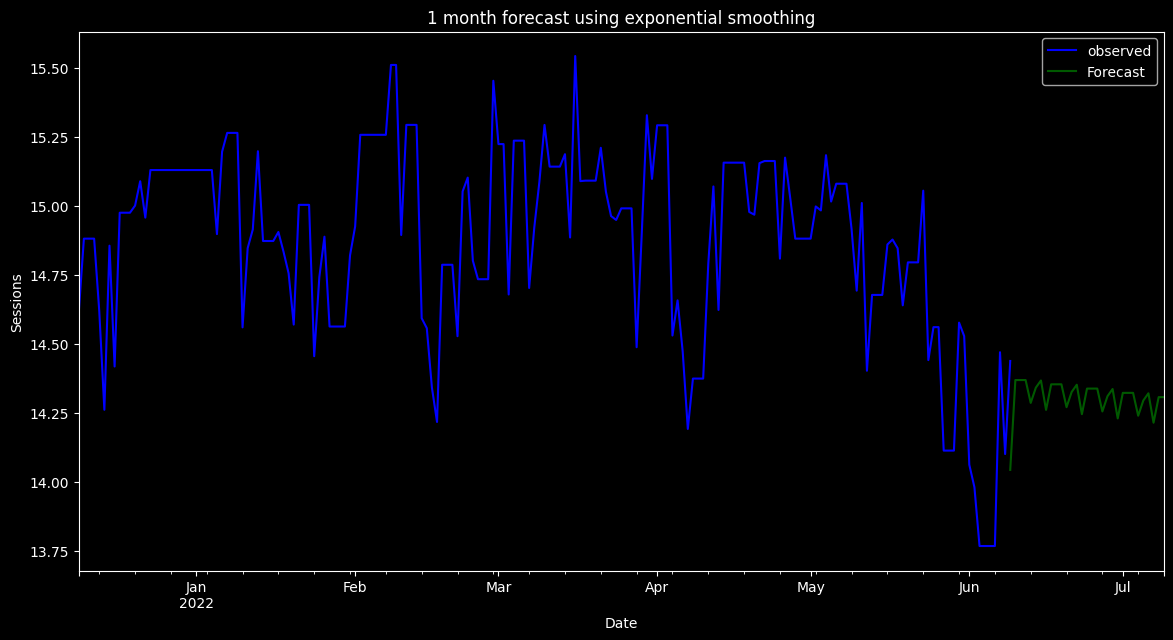

In [127]:
pred = exp_smoothing_model.predict(
    start=df_day_filled.index[-1], end=df_day_filled.index[-1] + DateOffset(months=1)
)
# print(pred)
# pred_ci = pred.conf_int()
y_forecasted = pred
y = df_day_filled
ax = y.plot(label="observed", color="b")
y_forecasted.plot(ax=ax, label="Forecast", alpha=0.7, figsize=(14, 7), color="g")
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel("Date")
ax.set_ylabel("Sessions")
plt.legend()
plt.title("1 month forecast using exponential smoothing")
plt.show()